In [49]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import PowerNorm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from scipy.stats import spearmanr

# import src.meanderpy_local as mp
# import importlib
# importlib.reload(meanderpy_local)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.rcParams.update({
    'font.sans-serif': 'Arial',
    'savefig.dpi': 600,
    'figure.dpi': 150,
    'font.size': 7,
    'figure.figsize': [4, 2.5],
    'axes.labelpad': 5,
    'axes.linewidth': 0.5,
    'xtick.major.width': 0.5,
    'ytick.major.width': 0.5,
    'axes.titlesize': 'medium',
    'legend.fontsize': 'medium',
    'text.usetex': False,
    'mathtext.fontset': 'stixsans',
    'mathtext.default': 'it',
})

pd.options.display.max_columns = 50

# import warnings
# warnings.filterwarnings('ignore')

centimeters = 1 / 2.54

In [50]:
centerline_df = pd.read_csv('1_input-data/centerline-points-with-idx.csv')

In [51]:
centerline = centerline_df.values
x_2022 = centerline[:,0]
y_2022 = centerline[:,1]
z_2022 = np.zeros(len(y_2022),float)

In [52]:
centerline_df

,x,y,bend,transect_idx
0,323838.9093,3342918.433,NaN,-285
1,323828.7214,3342895.604,NaN,-284
2,323818.8313,3342872.644,NaN,-283
3,323809.2876,3342849.538,NaN,-282
4,323800.1396,3342826.273,NaN,-281
...,...,...,...,...
805,325015.9275,3333257.304,NaN,520
806,325003.4548,3333235.643,NaN,521
807,324992.0210,3333213.417,NaN,522
808,324981.6617,3333190.671,NaN,523


In [206]:
nit = 1                   # number of iterations
W = 200.0                    # channel width (m)
D = 9.0                      # channel depth (m)
depths = D * np.ones((nit,))  # channel depths for different iterations  
pad = 100                    # padding (number of nodepoints along centerline)
deltas = 25.0                # sampling distance along centerline           
Cfs = 0.01015 * np.ones((nit,)) # dimensionless Chezy friction factor
crdist = 1.5 * W               # threshold distance at which cutoffs occur
kl = 60.0/(365*24*60*60.0)   # migration rate constant (m/s)
kv =  1.0e-12               # vertical slope-dependent erosion rate constant (m/s)
dt = 1*0.05*365*24*60*60.0     # time step (s)
dens = 1000                  # density of fluid (kg/m3)
saved_ts = 1                # which time steps will be saved
n_bends = 20                # approximate number of bends you want to model
Sl = 0.0                     # initial slope (matters more for submarine channels than rivers)
t1 = 500                    # time step when incision starts
t2 = 700                    # time step when lateral migration starts
t3 = 1200                    # time step when aggradation starts
aggr_factor = 2e-9         # aggradation factor (m/s, about 0.18 m/year, it kicks in after t3)

k = 1.0                        # HK constant
pad1 = int(pad/10.0)

meanderpy functions (edited)

In [207]:
def compute_curvature(x,y):
    dx = np.gradient(x) # first derivatives
    dy = np.gradient(y)      
    ddx = np.gradient(dx) # second derivatives 
    ddy = np.gradient(dy) 
    curvature = (dx*ddy-dy*ddx)/((dx**2+dy**2)**1.5)
    return curvature

def compute_derivatives(x,y,z):
    dx = np.gradient(x) # first derivatives
    dy = np.gradient(y)   
    dz = np.gradient(z)   
    ds = np.sqrt(dx**2+dy**2+dz**2)
    s = np.hstack((0,np.cumsum(ds[1:])))
    return dx, dy, dz, ds, s

def compute_migration_rate(pad, ns, ds, alpha, R0, omega=-1.0, gamma=2.5):
    R1 = np.zeros(ns)  # preallocate adjusted channel migration rate
    pad1 = int(pad / 10.0)  # padding at upstream end can be shorter than padding on downstream end
    if pad1 < 5:
        pad1 = 5
    for i in range(pad1, ns - pad):
        si2 = np.hstack((np.array([0]), np.cumsum(ds[i - 1::-1])))  # distance along centerline, backwards from current point
        G = np.exp(-alpha * si2)  # convolution vector
        R1[i] = omega * R0[i] + gamma * np.sum(R0[i::-1] * G) / np.sum(G)  # main equation
    return R1

def migrate_one_step(x,y,z,W,kl,dt,k,Cf,D,pad,pad1,omega=-1.0,gamma=2.5):
    ns=len(x)
    curv = compute_curvature(x,y)
    dx, dy, dz, ds, s = compute_derivatives(x,y,z)
    # sinuosity = s[-1]/(x[-1]-x[0])
    sinuosity = s[-1]/(np.sqrt((x[-1]-x[0])**2 + (y[-1]-y[0])**2))
    curv = W*curv # dimensionless curvature
    R0 = kl*curv # simple linear relationship between curvature and nominal migration rate
    alpha = k*2*Cf/D # exponent for convolution function G
    R1 = compute_migration_rate(pad,ns,ds,alpha,R0)
    R1 = sinuosity**(-2/3.0)*R1
    # calculate new centerline coordinates:
    dy_ds = dy[pad1:ns-pad+1]/ds[pad1:ns-pad+1]
    dx_ds = dx[pad1:ns-pad+1]/ds[pad1:ns-pad+1]
    x_old = x.copy()
    y_old = y.copy()
    # adjust x and y coordinates (this *is* the migration):
    x[pad1:ns-pad+1] = x[pad1:ns-pad+1] + R1[pad1:ns-pad+1]*dy_ds*dt  
    y[pad1:ns-pad+1] = y[pad1:ns-pad+1] - R1[pad1:ns-pad+1]*dx_ds*dt 
    return curv, R1, x_old, y_old, x, y, s

In [208]:
cfs_original = 0.01015

curv, r1, x_old, y_old, x, y, s = migrate_one_step(x_2022,y_2022,z_2022,W,kl,dt,k,cfs_original,D,pad,pad1,omega=-1.0,gamma=2.5)
out_dist = np.sqrt((x-x_old)**2 + (y-y_old)**2)

r1 = r1 * 365 * 24 * 60 * 60 # convert from m / s to m / year

centerline_df['curv'] = curv
centerline_df['r1'] = r1
centerline_df['s'] = s

cfs_02 = 1

curv_02, r1_02, x_old_02, y_old_02, x_02, y_02, s_02 = migrate_one_step(x_2022,y_2022,z_2022,W,kl,dt,k,cfs_02,D,pad,pad1,omega=-1.0,gamma=2.5)
out_dist_02 = np.sqrt((x_02-x_old_02)**2 + (y_02-y_old_02)**2)

centerline_df['r1_02'] = r1_02
centerline_df['s_02'] = s_02

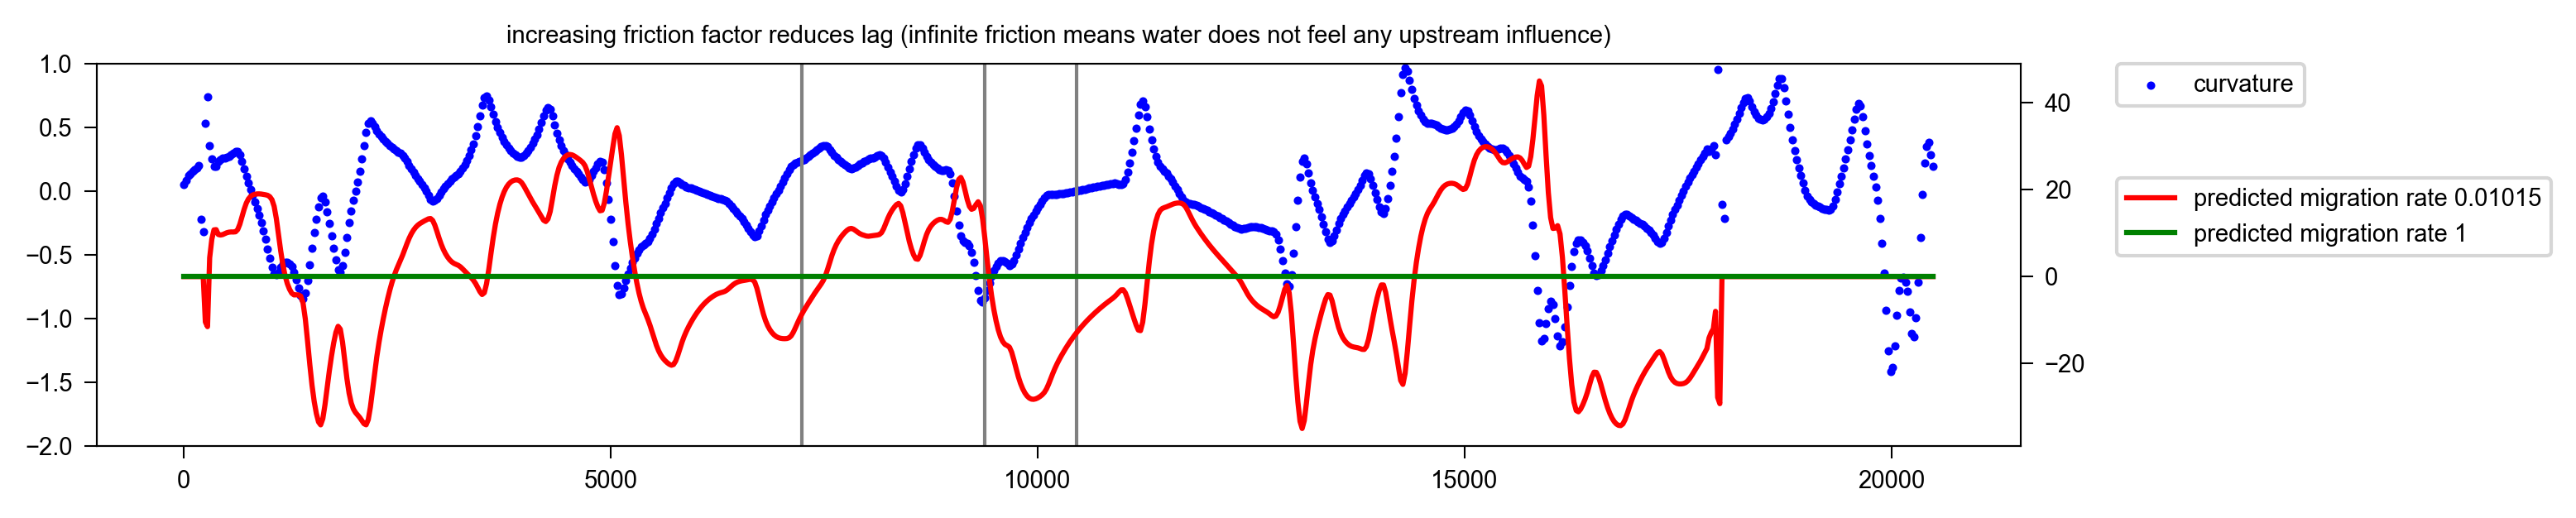

In [209]:
fig, ax = plt.subplots(figsize=(10, 2))
scatter = ax.scatter(s, curv, s=2, label='curvature', color='blue')
ax.set_ylim(-2, 1)

ax2 = ax.twinx()
ax2.plot(s, r1, color='red', label=f'predicted migration rate {cfs_original}')
ax2.plot(s, r1_02, color='green', label=f'predicted migration rate {cfs_02}')
# ax2.set_ylim(-2e-6, 4e-6)

ax.axvline(s[centerline_df[centerline_df['transect_idx'] == 1].index], color='grey', linestyle='-', lw=1)
ax.axvline(s[centerline_df[centerline_df['transect_idx'] == 86].index], color='grey', linestyle='-', lw=1)
ax.axvline(s[centerline_df[centerline_df['transect_idx'] == 128].index], color='grey', linestyle='-', lw=1)

ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
ax2.legend(loc='upper left', bbox_to_anchor=(1.05, 0.7), borderaxespad=0.)
ax.set_title('increasing friction factor reduces lag (infinite friction means water does not feel any upstream influence)')

fig.savefig('3_output-data/figures/curvature-and-predicted-migration-rate.png', bbox_inches='tight', dpi=300)

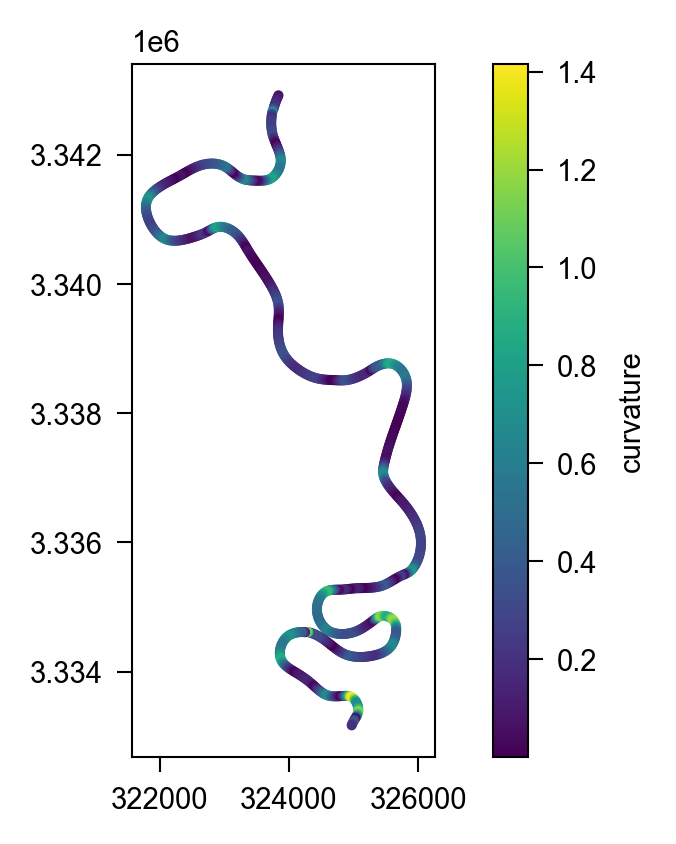

In [210]:
fig, ax = plt.subplots(figsize=(5, 3))
scatter = ax.scatter(x_2022, y_2022, c=abs(curv), cmap='viridis', s=2)
ax.set_aspect('equal')
fig.colorbar(scatter, label='curvature')

In [211]:
r1_df = pd.DataFrame({'x_2022': x_2022, 'y_2022': y_2022, 'abs_r1': abs(r1)})
curv_df = pd.DataFrame({'x_2022': x_2022, 'y_2022': y_2022, 'abs_r1': abs(curv)})

r1_local = r1_df[(r1_df['x_2022'] >= 323392) &
                 (r1_df['x_2022'] <= 327471) &
                 (r1_df['y_2022'] >= 3337321) &
                 (r1_df['y_2022'] <= 3340168)]

curv_local = curv_df[(curv_df['x_2022'] >= 323392) &
                 (curv_df['x_2022'] <= 327471) &
                 (curv_df['y_2022'] >= 3337321) &
                 (curv_df['y_2022'] <= 3340168)]

# fig, ax = plt.subplots(figsize=(5,3))
# scatter = ax.scatter(r1_local.x_2022, r1_local.y_2022, c=r1_local.abs_r1, cmap='BuPu', s=10)
# ax.set_aspect('equal')
# cb = fig.colorbar(scatter, label='predicted centerline migration rates, $R_{1}$ (m $\cdot$ s$^{-1}$)')
# cb.set_ticks(np.arange(1, 10, 2) * 1e-7)
# ax.set_xlabel('x coordinate (m)')
# ax.set_ylabel('y coordinate (m)')
# fig.savefig('centerline-migration-rate.pdf', bbox_inches='tight')

<>:15: SyntaxWarning: invalid escape sequence '\c'
<>:15: SyntaxWarning: invalid escape sequence '\c'
C:\Users\mn25983\AppData\Local\Temp\ipykernel_35092\866497727.py:15: SyntaxWarning: invalid escape sequence '\c'
  cb = fig.colorbar(line, label='predicted centerline migration rate, $R_{1}$ (m $\cdot$ yr$^{-1}$)')


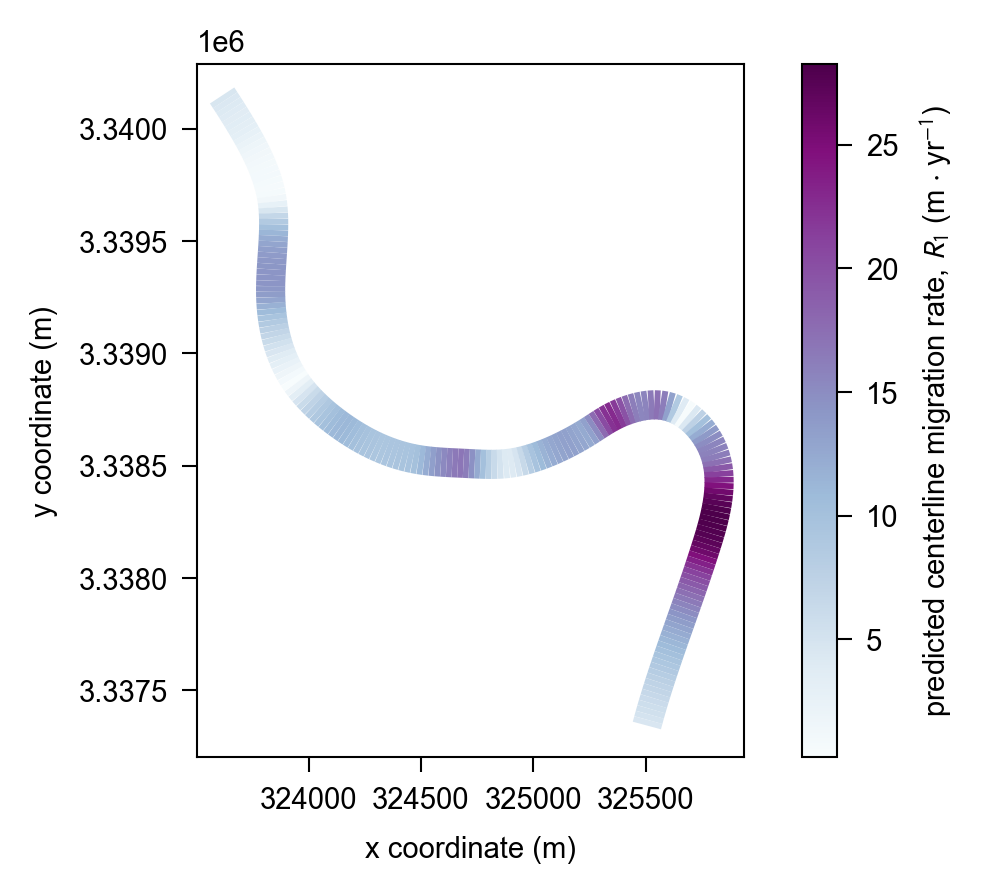

In [212]:
from matplotlib.collections import LineCollection

fig, ax = plt.subplots(figsize=(5,3))

# create line segments
points = np.array([r1_local.x_2022, r1_local.y_2022]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# create line collection with color mapping
lc = LineCollection(segments, cmap='BuPu', linewidths=7)
lc.set_array(r1_local.abs_r1[:-1])  # color each segment by starting point value
line = ax.add_collection(lc)

ax.set_aspect('equal')
cb = fig.colorbar(line, label='predicted centerline migration rate, $R_{1}$ (m $\cdot$ yr$^{-1}$)')
# cb.set_ticks(np.arange(1, 10, 2) * 1e-7)
ax.set_xlabel('x coordinate (m)')
ax.set_ylabel('y coordinate (m)')
ax.autoscale()
fig.savefig('3_output-data/figures/centerline-migration-rate.pdf', bbox_inches='tight')

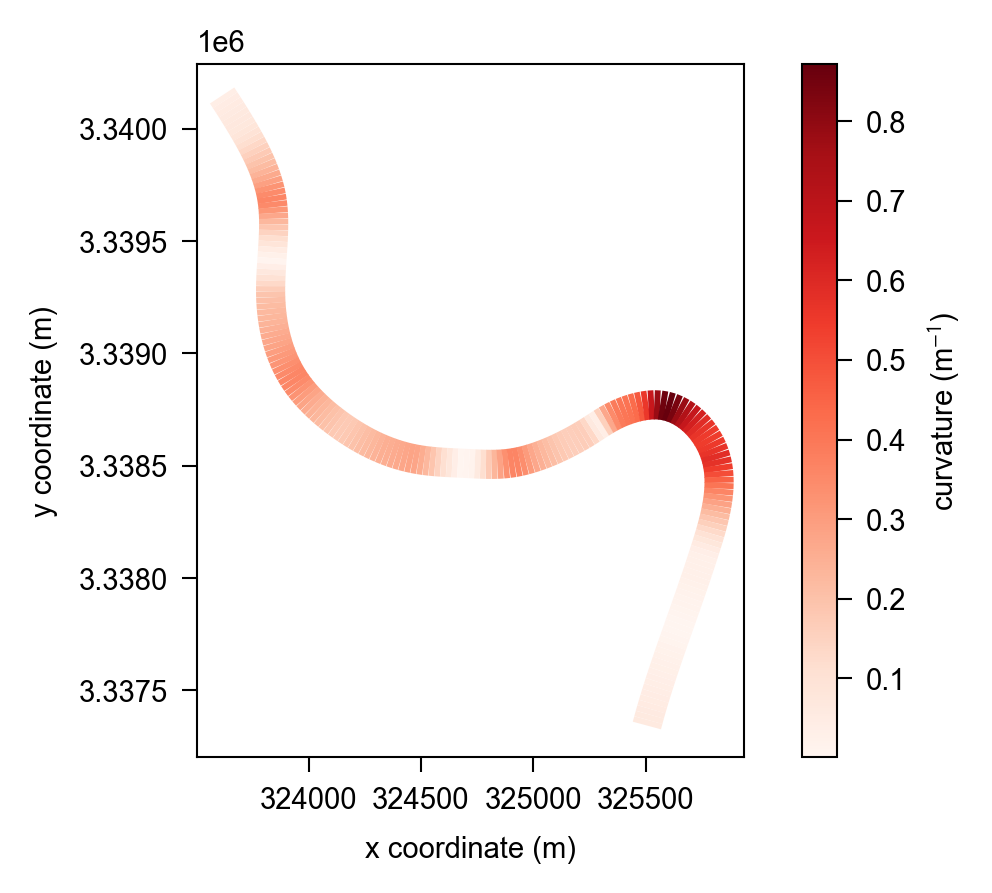

In [213]:
fig, ax = plt.subplots(figsize=(5,3))

# create line segments
points = np.array([curv_local.x_2022, curv_local.y_2022]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# create line collection with color mapping
lc = LineCollection(segments, cmap='Reds', linewidths=7)
lc.set_array(curv_local.abs_r1[:-1])  # color each segment by starting point value
line = ax.add_collection(lc)

ax.set_aspect('equal')
cb = fig.colorbar(line, label='curvature (m$^{-1}$)')
# cb.set_ticks(np.arange(1, 10, 2) * 1e-7)
ax.set_xlabel('x coordinate (m)')
ax.set_ylabel('y coordinate (m)')
ax.autoscale()
fig.savefig('3_output-data/figures/centerline-curvature-25m.pdf', bbox_inches='tight')

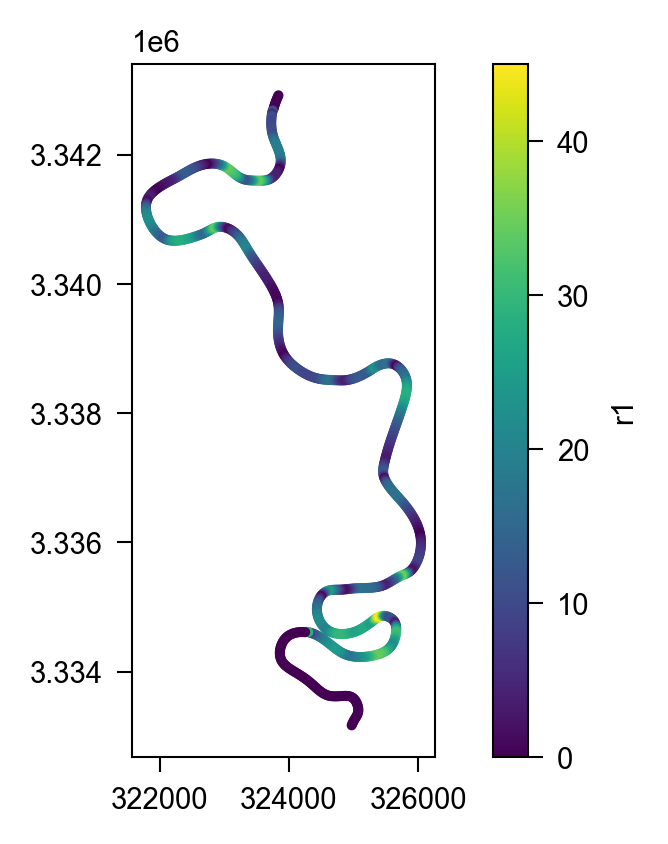

In [214]:
fig, ax = plt.subplots(figsize=(5,3))
scatter = ax.scatter(x_2022, y_2022, c=abs(r1), cmap='viridis', s=2)
ax.set_aspect('equal')
fig.colorbar(scatter, label='r1')

In [215]:
alpha_metadata = pd.read_parquet('2_intermediate-data/alpha_metadata.parquet')

In [216]:
alpha_metadata.groupby('transect_idx')['area'].median().describe()

count    122.000000
mean       1.461425
std        0.726723
min        0.562986
25%        1.039405
50%        1.390216
75%        1.611595
max        5.783567
Name: area, dtype: float64

In [217]:
curvature_erosion = pd.merge(alpha_metadata, centerline_df, on='transect_idx', how='left')
curvature_erosion.loc[curvature_erosion['transect_idx'] < 82, 'bend'] = 1
curvature_erosion.loc[curvature_erosion['transect_idx'] >= 82, 'bend'] = 2

date_pairs = curvature_erosion[['alphashape_survey_date_1', 'alphashape_survey_date_2']].drop_duplicates()

flow = pd.read_parquet('1_input-data/hf_liberty_corr_final_2007-09-30_2025-10-01.parquet')

lookup = []
for _, row in date_pairs.iterrows():
    start_date = row['alphashape_survey_date_1']
    end_date = row['alphashape_survey_date_2']
    
    mask = (flow['timestamp'] >= start_date) & (flow['timestamp'] <= end_date)
    max_val = flow.loc[mask, 'submerged_bank_perc'].max()
    lookup.append([start_date, end_date, max_val])

flow_pairs = pd.DataFrame(lookup, columns=['alphashape_survey_date_1', 'alphashape_survey_date_2', 'max_submerged_bank_percent'])

curvature_erosion = curvature_erosion.merge(flow_pairs, on=['alphashape_survey_date_1', 'alphashape_survey_date_2'])

flow_pairs = pd.concat([flow_pairs.assign(bend=1), flow_pairs.assign(bend=2)], ignore_index=True)

In [218]:
flow_pairs

,alphashape_survey_date_1,alphashape_survey_date_2,max_submerged_bank_percent,bend
0,2022-04-15,2022-06-17,80.002549,1
1,2022-06-17,2022-09-21,64.868347,1
2,2022-09-21,2023-01-07,87.246007,1
3,2023-01-07,2023-03-03,100.407523,1
4,2023-03-03,2023-05-25,103.582315,1
5,2023-05-25,2023-09-17,65.854690,1
6,2023-09-17,2023-12-08,67.919846,1
7,2023-12-08,2024-02-27,119.517922,1
8,2024-02-27,2024-09-06,127.223728,1
9,2024-09-06,2025-04-04,102.873381,1


In [219]:
before_dates = date_pairs.alphashape_survey_date_1.unique()
after_dates = date_pairs.alphashape_survey_date_2.unique()

all_dates = pd.concat([pd.Series(before_dates), pd.Series(after_dates)]).unique()
all_dates

<DatetimeArray>
['2022-04-15 00:00:00', '2022-06-17 00:00:00', '2022-09-21 00:00:00',
 '2023-01-07 00:00:00', '2023-03-03 00:00:00', '2023-05-25 00:00:00',
 '2023-09-17 00:00:00', '2023-12-08 00:00:00', '2024-02-27 00:00:00',
 '2024-09-06 00:00:00', '2025-04-04 00:00:00', '2025-08-22 00:00:00']
Length: 12, dtype: datetime64[ns]

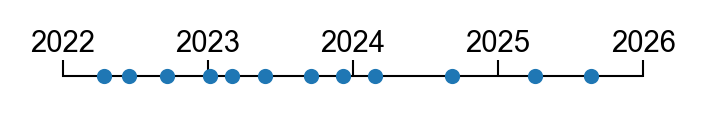

In [220]:
import datetime

fig, ax = plt.subplots(figsize=(6 * centimeters, 1 * centimeters))
ax.tick_params(axis='x', direction='in', length=4, pad=0.5)

ax.axhline(0, color='black', lw=0.5, zorder=0)
ax.scatter(all_dates, np.zeros(len(all_dates)), s=7, alpha=1, zorder=3)

start_date = datetime.datetime(2022, 1, 1)
end_date = datetime.datetime(2026, 1, 1)
ax.set_xlim(start_date, end_date)

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1]))

ax.set_ylim(-0.01, 0.019)
ax.set_yticks([])

for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_axisbelow(True)

plt.tight_layout()
plt.show()
fig.savefig('3_output-data/figures/centerline_dates.pdf', bbox_inches='tight', pad_inches=0.05, transparent=True)

In [221]:
bathy_profile = pd.read_csv('1_input-data/bathy-profile.txt', sep='\t', header=None, names=['distance', 'z'])

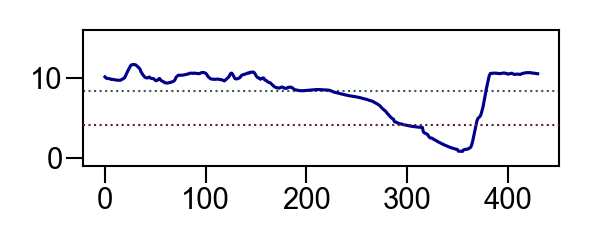

In [222]:
bathy_profile_filled = bathy_profile.copy()
bathy_profile_filled['z'] = bathy_profile_filled['z'].interpolate(method='cubic')

fig, ax = plt.subplots(figsize=(5.2 * centimeters, 1.5 * centimeters))
ax.plot(bathy_profile_filled.distance, bathy_profile_filled.z, '-', lw=0.75, color='darkblue')
ax.axhline(flow['crr_stage_m'].quantile(.9), color="#375C49", lw=0.5, zorder=0, linestyle=':')
ax.axhline(flow['crr_stage_m'].quantile(.5), color="#5E2133", lw=0.5, zorder=10, linestyle=':')
# ax.axhline(flow['crr_stage_m'].quantile(1), color='black', lw=0.5, zorder=0)
ax.set_ylim(-1, 16)
ax.tick_params(axis='both', length=4, pad=1)
ax.set_yticks([0, 10])

# xlim = ax.get_xlim()
# ax.annotate('m', xy=(xlim[1], 0), xytext=(-5, -12), 
#             textcoords='offset points', fontsize=7, ha='left')

fig.savefig('3_output-data/figures/bathy_profile.pdf', bbox_inches='tight', pad_inches=0.05)

In [223]:
percentiles = flow['crr_stage_above_bed_m'].quantile([0.05, 0.25, 0.5, 0.75, 0.95])
print(percentiles)

0.05    0.919279
0.25    1.156219
0.50    1.485981
0.75    3.552487
0.95    6.398208
Name: crr_stage_above_bed_m, dtype: float64


In [224]:
curvature_erosion['max_area'] = curvature_erosion.groupby(['bend', 'alphashape_survey_date_1'])['area'].transform('max')
curvature_erosion['relative_area'] = curvature_erosion['area'] / curvature_erosion['max_area']

curvature_erosion['med_area'] = curvature_erosion.groupby(['bend', 'alphashape_survey_date_1'])['area'].transform('median')
curvature_erosion['relative_area_med'] = curvature_erosion['area'] / curvature_erosion['med_area']

curvature_erosion['summed_area'] = curvature_erosion.groupby('transect_idx')['area'].transform('sum')

In [225]:
curvature_erosion['survey_interval_yrs'] = (
    (curvature_erosion['alphashape_survey_date_2'] - 
     curvature_erosion['alphashape_survey_date_1']).dt.days / 365.25
)

curvature_erosion['mean_retreat_m'] = curvature_erosion['area'] / 6.0
curvature_erosion['mean_retreat_rate_m_yr'] = curvature_erosion['mean_retreat_m'] / curvature_erosion['survey_interval_yrs']
curvature_erosion

,transect_idx,alphashape_survey_date_1,alphashape_survey_date_2,alpha,area,polygon_index,n_points,coverage_fraction,alpha_changed,error_info,x,y,bend,curv,r1,s,r1_02,s_02,max_submerged_bank_percent,max_area,relative_area,med_area,relative_area_med,summed_area,survey_interval_yrs,mean_retreat_m,mean_retreat_rate_m_yr
0,3,2022-04-15,2022-06-17,3.0,0.955293,0.0,318,0.940252,False,None,323852.7975,3339100.731,1.0,0.260003,-6.959379,7287.728265,4.551588e-07,7289.043517,80.002549,2.056960,0.464420,0.535207,1.784903,14.328039,0.172485,0.159215,0.923071
1,3,2022-06-17,2022-09-21,3.0,2.116078,1.0,485,0.993814,False,None,323852.7975,3339100.731,1.0,0.260003,-6.959379,7287.728265,4.551588e-07,7289.043517,64.868347,3.169615,0.667613,0.958647,2.207358,14.328039,0.262834,0.352680,1.341836
2,3,2022-09-21,2023-01-07,3.0,1.059514,2.0,156,0.826923,False,None,323852.7975,3339100.731,1.0,0.260003,-6.959379,7287.728265,4.551588e-07,7289.043517,87.246007,11.197343,0.094622,1.012604,1.046325,14.328039,0.295688,0.176586,0.597203
3,3,2023-01-07,2023-03-03,3.0,1.573249,3.0,406,1.000000,False,None,323852.7975,3339100.731,1.0,0.260003,-6.959379,7287.728265,4.551588e-07,7289.043517,100.407523,9.622032,0.163505,1.466070,1.073107,14.328039,0.150582,0.262208,1.741301
4,3,2023-03-03,2023-05-25,3.0,1.827102,4.0,409,0.995110,False,None,323852.7975,3339100.731,1.0,0.260003,-6.959379,7287.728265,4.551588e-07,7289.043517,103.582315,10.544227,0.173280,1.827102,1.000000,14.328039,0.227242,0.304517,1.340058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,131,2025-04-04,2025-08-22,3.0,1.472754,1250.0,427,1.000000,False,None,325624.1206,3337725.770,2.0,0.011381,-11.220798,10527.667009,2.047181e-08,10530.002282,116.836301,23.828125,0.061807,4.283107,0.343852,1.472754,0.383299,0.245459,0.640385
1253,132,2025-04-04,2025-08-22,3.0,2.915749,1251.0,651,1.000000,False,None,325616.0991,3337702.092,2.0,0.014872,-10.676573,10552.663540,2.650439e-08,10554.997840,116.836301,23.828125,0.122366,4.283107,0.680756,2.915749,0.383299,0.485958,1.267830
1254,133,2025-04-04,2025-08-22,3.0,1.326483,1252.0,366,1.000000,False,None,325608.1149,3337678.401,2.0,0.018323,-10.150824,10577.659685,3.251592e-08,10579.992840,116.836301,23.828125,0.055669,4.283107,0.309701,1.326483,0.383299,0.221081,0.576783
1255,134,2025-04-04,2025-08-22,3.0,1.405399,1253.0,417,1.000000,False,None,325600.1788,3337654.694,2.0,0.021809,-9.644991,10602.655114,3.856897e-08,10604.986971,116.836301,23.828125,0.058981,4.283107,0.328126,1.405399,0.383299,0.234233,0.611097


In [226]:
unique_r1 = abs(curvature_erosion['r1']).drop_duplicates()
bins, bin_edges = pd.qcut(unique_r1, q=10, retbins=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

curvature_erosion['r1_bin'] = pd.cut(abs(curvature_erosion['r1']), 
                                    bins=bin_edges, 
                                    labels=bin_centers, 
                                    include_lowest=True)

In [227]:
bins, bin_edges = pd.qcut(abs(curvature_erosion['r1'].drop_duplicates()), q=10, retbins=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# apply bin edges to full dataset
full_bins = pd.cut(abs(curvature_erosion['r1']), bins=bin_edges, include_lowest=True)
curvature_erosion['r1_bin'] = full_bins.cat.codes.map(dict(enumerate(bin_centers)))

In [228]:
curvature_erosion_threshold = curvature_erosion[curvature_erosion['area'] > 1.5]

<>:19: SyntaxWarning: invalid escape sequence '\c'
<>:19: SyntaxWarning: invalid escape sequence '\c'
C:\Users\mn25983\AppData\Local\Temp\ipykernel_35092\2658219903.py:19: SyntaxWarning: invalid escape sequence '\c'
  ax.set_xlabel('predicted centerline migration rate, $R_{1}$ (m $\cdot$ yr$^{-1}$)')


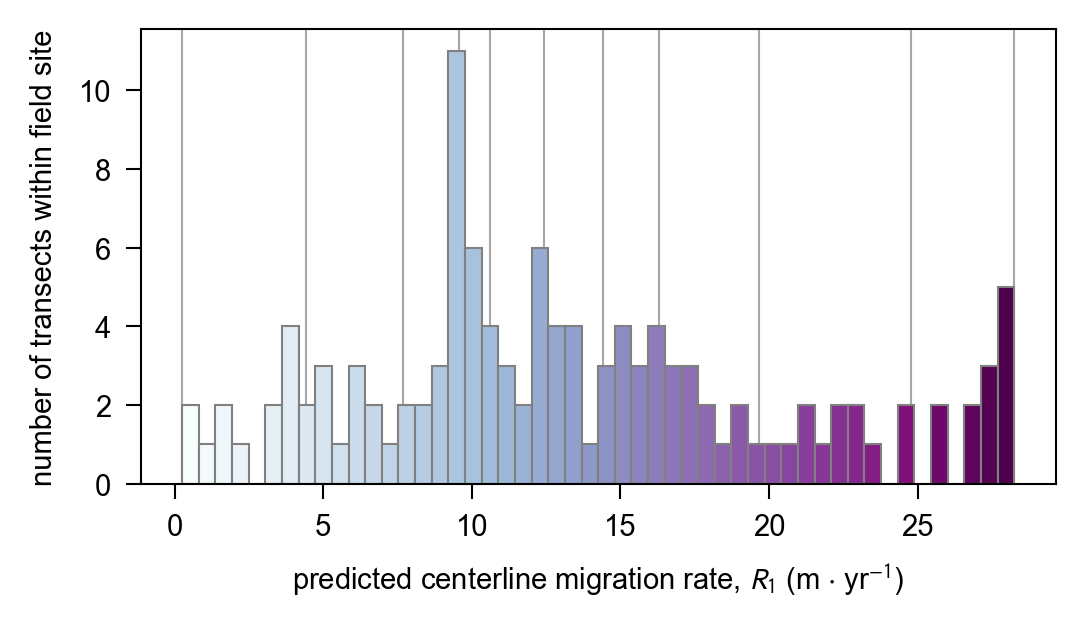

In [278]:
fig, ax = plt.subplots(figsize=(10 * centimeters, 5 * centimeters))
counts, hist_edges, patches = ax.hist(abs(curvature_erosion['r1'].unique()), bins=50)
hist_centers = (hist_edges[:-1] + hist_edges[1:]) / 2

norm = plt.Normalize(vmin=hist_centers.min(), vmax=hist_centers.max())
cmap = plt.cm.BuPu

for i, patch in enumerate(patches):
    color = cmap(norm(hist_centers[i]))
    patch.set_facecolor(color)
    patch.set_edgecolor('gray')
    patch.set_linewidth(0.5)

# add vertical lines at bin edges
for edge in bin_edges:
    ax.axvline(edge, color='gray', linewidth=0.5, alpha=0.7, zorder=0)

# ax.set_xticks(np.arange(1, 10, 2) * 1e-7)
ax.set_xlabel('predicted centerline migration rate, $R_{1}$ (m $\cdot$ yr$^{-1}$)')
ax.set_ylabel('number of transects within field site')
fig.savefig('3_output-data/figures/curvature_histogram.pdf', bbox_inches='tight', pad_inches=0.05)

In [230]:
# colored by qcut bins

# fig, ax = plt.subplots(figsize=(10 * centimeters, 5 * centimeters))

# counts, hist_edges, patches = ax.hist(abs(curvature_erosion['r1'].unique()), bins=50)
# hist_centers = (hist_edges[:-1] + hist_edges[1:]) / 2

# qcut_bin_indices = np.digitize(hist_centers, bin_edges) - 1
# qcut_bin_indices = np.clip(qcut_bin_indices, 0, len(bin_centers) - 1)

# norm = plt.Normalize(vmin=bin_centers.min(), vmax=bin_centers.max())
# cmap = plt.cm.BuPu

# for i, patch in enumerate(patches):
#     color = cmap(norm(bin_centers[qcut_bin_indices[i]]))
#     patch.set_facecolor(color)
#     patch.set_edgecolor('gray')
#     patch.set_linewidth(0.5)

# ax.set_xticks(np.arange(1, 10, 2) * 1e-7)
# ax.set_xlabel('predicted centerline migration rate, $R_{1}$ (m $\cdot$ s$^{-1}$)')
# ax.set_ylabel('number of transects')

# fig.savefig('curvature_histogram.pdf', bbox_inches='tight', pad_inches=0.05)

#### bin by flow

In [231]:
curvature_erosion['r1_pred_for_flood_m'] = curvature_erosion['r1'] * curvature_erosion['survey_interval_yrs']
curvature_erosion

,transect_idx,alphashape_survey_date_1,alphashape_survey_date_2,alpha,area,polygon_index,n_points,coverage_fraction,alpha_changed,error_info,x,y,bend,curv,r1,s,r1_02,s_02,max_submerged_bank_percent,max_area,relative_area,med_area,relative_area_med,summed_area,survey_interval_yrs,mean_retreat_m,mean_retreat_rate_m_yr,r1_bin,r1_pred_for_flood_m
0,3,2022-04-15,2022-06-17,3.0,0.955293,0.0,318,0.940252,False,None,323852.7975,3339100.731,1.0,0.260003,-6.959379,7287.728265,4.551588e-07,7289.043517,80.002549,2.056960,0.464420,0.535207,1.784903,14.328039,0.172485,0.159215,0.923071,6.044922,-1.200386
1,3,2022-06-17,2022-09-21,3.0,2.116078,1.0,485,0.993814,False,None,323852.7975,3339100.731,1.0,0.260003,-6.959379,7287.728265,4.551588e-07,7289.043517,64.868347,3.169615,0.667613,0.958647,2.207358,14.328039,0.262834,0.352680,1.341836,6.044922,-1.829159
2,3,2022-09-21,2023-01-07,3.0,1.059514,2.0,156,0.826923,False,None,323852.7975,3339100.731,1.0,0.260003,-6.959379,7287.728265,4.551588e-07,7289.043517,87.246007,11.197343,0.094622,1.012604,1.046325,14.328039,0.295688,0.176586,0.597203,6.044922,-2.057804
3,3,2023-01-07,2023-03-03,3.0,1.573249,3.0,406,1.000000,False,None,323852.7975,3339100.731,1.0,0.260003,-6.959379,7287.728265,4.551588e-07,7289.043517,100.407523,9.622032,0.163505,1.466070,1.073107,14.328039,0.150582,0.262208,1.741301,6.044922,-1.047956
4,3,2023-03-03,2023-05-25,3.0,1.827102,4.0,409,0.995110,False,None,323852.7975,3339100.731,1.0,0.260003,-6.959379,7287.728265,4.551588e-07,7289.043517,103.582315,10.544227,0.173280,1.827102,1.000000,14.328039,0.227242,0.304517,1.340058,6.044922,-1.581461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,131,2025-04-04,2025-08-22,3.0,1.472754,1250.0,427,1.000000,False,None,325624.1206,3337725.770,2.0,0.011381,-11.220798,10527.667009,2.047181e-08,10530.002282,116.836301,23.828125,0.061807,4.283107,0.343852,1.472754,0.383299,0.245459,0.640385,11.509008,-4.300922
1253,132,2025-04-04,2025-08-22,3.0,2.915749,1251.0,651,1.000000,False,None,325616.0991,3337702.092,2.0,0.014872,-10.676573,10552.663540,2.650439e-08,10554.997840,116.836301,23.828125,0.122366,4.283107,0.680756,2.915749,0.383299,0.485958,1.267830,11.509008,-4.092321
1254,133,2025-04-04,2025-08-22,3.0,1.326483,1252.0,366,1.000000,False,None,325608.1149,3337678.401,2.0,0.018323,-10.150824,10577.659685,3.251592e-08,10579.992840,116.836301,23.828125,0.055669,4.283107,0.309701,1.326483,0.383299,0.221081,0.576783,10.084693,-3.890802
1255,134,2025-04-04,2025-08-22,3.0,1.405399,1253.0,417,1.000000,False,None,325600.1788,3337654.694,2.0,0.021809,-9.644991,10602.655114,3.856897e-08,10604.986971,116.836301,23.828125,0.058981,4.283107,0.328126,1.405399,0.383299,0.234233,0.611097,10.084693,-3.696917


Text(0, 0.5, 'mean bank retreat (m)')

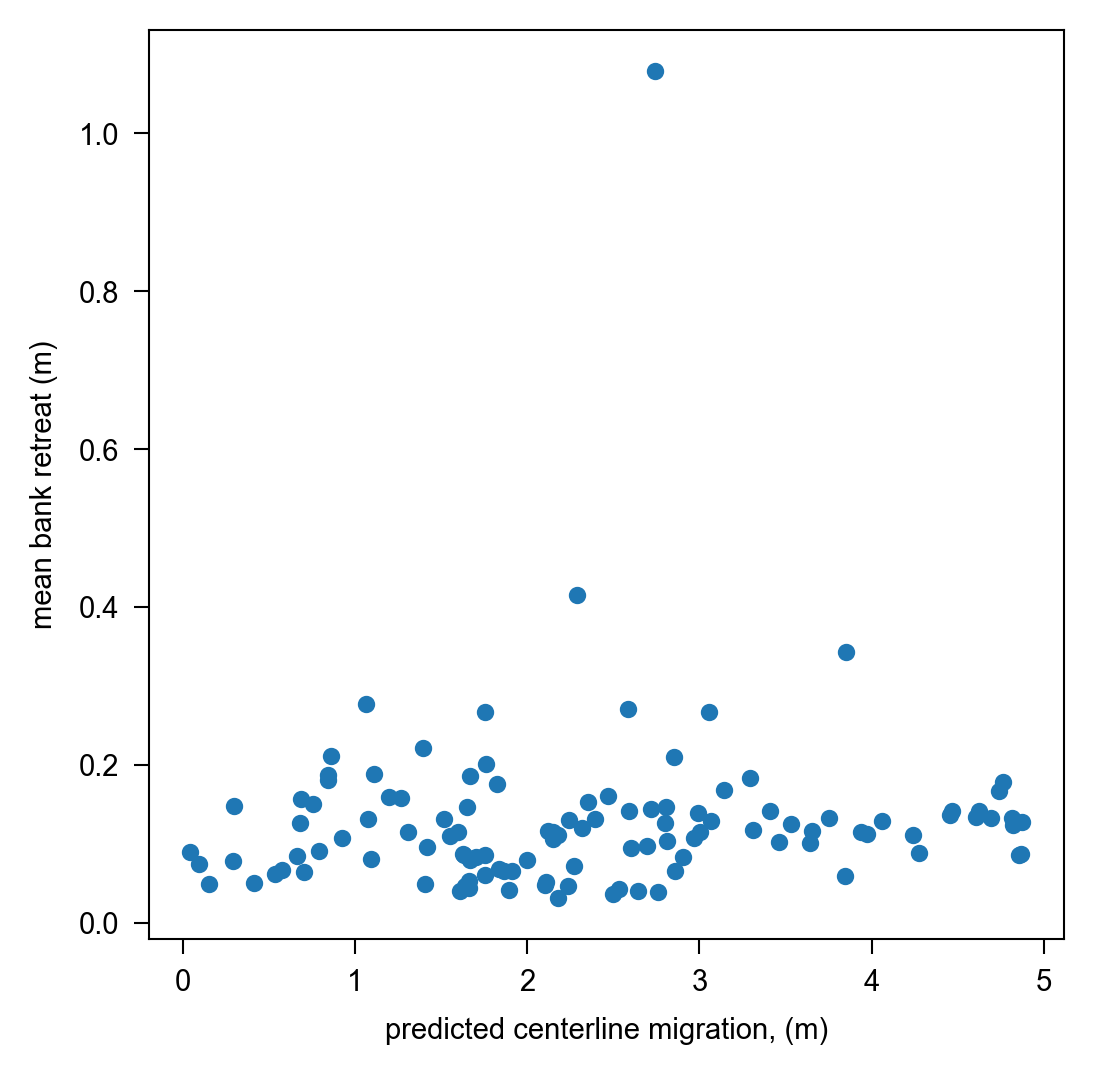

In [233]:
fig, ax = plt.subplots(figsize=(10 * centimeters, 10 * centimeters))

small_flood = curvature_erosion[curvature_erosion['alphashape_survey_date_1'] == '2022-04-15']
ax.scatter(abs(small_flood['r1_pred_for_flood_m']), small_flood['mean_retreat_m'], s=10)
ax.set_xlabel('predicted centerline migration, (m)')
ax.set_ylabel('mean bank retreat (m)')
# ax.set_xlim(0, 3)
# ax.set_aspect('equal')

In [234]:
curvature_erosion['alphashape_survey_date_1'].unique(
)

<DatetimeArray>
['2022-04-15 00:00:00', '2022-06-17 00:00:00', '2022-09-21 00:00:00',
 '2023-01-07 00:00:00', '2023-03-03 00:00:00', '2023-05-25 00:00:00',
 '2023-09-17 00:00:00', '2023-12-08 00:00:00', '2024-02-27 00:00:00',
 '2024-09-06 00:00:00', '2025-04-04 00:00:00']
Length: 11, dtype: datetime64[ns]

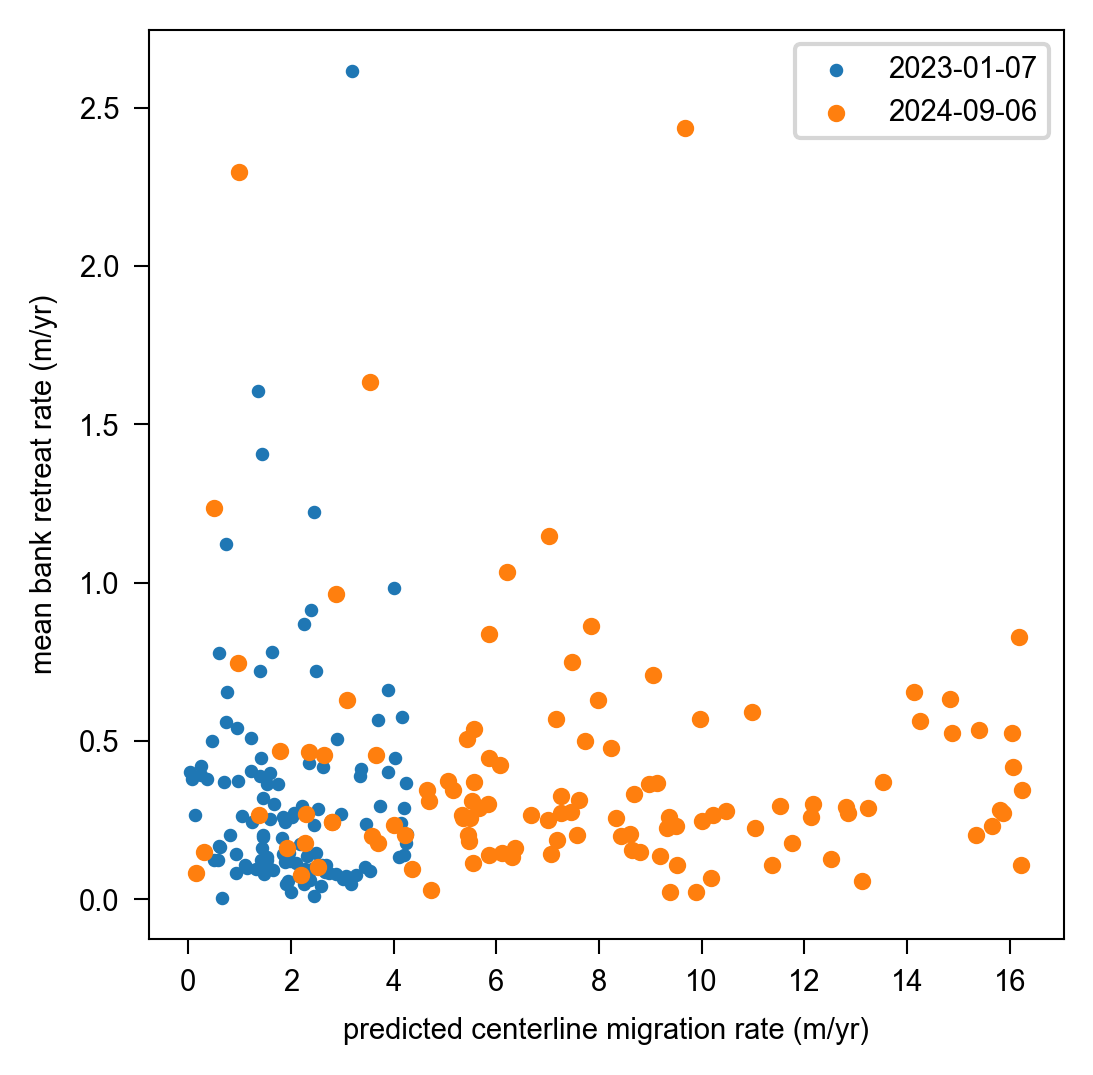

In [277]:

fig, ax = plt.subplots(figsize=(10 * centimeters, 10 * centimeters))

# large_flood0 = curvature_erosion[curvature_erosion['alphashape_survey_date_1'] == '2023-12-08']
# ax.scatter(abs(large_flood0['r1']), large_flood0['mean_retreat_rate_m_yr'], s=5, label='2023-12-08')

small_flood = curvature_erosion[curvature_erosion['alphashape_survey_date_1'] == '2023-01-07']
ax.scatter(abs(small_flood['r1_pred_for_flood_m']), small_flood['mean_retreat_m'], s=5, label='2023-01-07')

# large_flood = curvature_erosion[curvature_erosion['alphashape_survey_date_1'] == '2024-02-27']
# ax.scatter(abs(large_flood['r1']), large_flood['mean_retreat_rate_m_yr'], s=5, label='2024-02-27')

large_flood2 = curvature_erosion[curvature_erosion['alphashape_survey_date_1'] == '2024-09-06']
ax.scatter(abs(large_flood2['r1_pred_for_flood_m']), large_flood2['mean_retreat_m'], s=10, label='2024-09-06')

# large_flood3 = curvature_erosion[curvature_erosion['alphashape_survey_date_1'] == '2025-04-04']
# ax.scatter(abs(large_flood3['r1']), large_flood3['mean_retreat_rate_m_yr'], s=5, label='2025-04-04')

# ax.plot([0, 30], [0, 30])

# add annotation of rho value for each one

ax.set_xlabel('predicted centerline migration (m)')
ax.set_ylabel('mean bank retreat (m)')

ax.set_xlabel('predicted centerline migration rate (m/yr)')
ax.set_ylabel('mean bank retreat rate (m/yr)')
ax.legend()

# ax.set_xlim(0, 3)
# ax.set_aspect('equal')

<>:24: SyntaxWarning: invalid escape sequence '\c'
<>:24: SyntaxWarning: invalid escape sequence '\c'
C:\Users\mn25983\AppData\Local\Temp\ipykernel_35092\1791076305.py:24: SyntaxWarning: invalid escape sequence '\c'
  axes[-1].set_xlabel('predicted centerline migration rate, $R_{1}$ (m $\cdot$ yr$^{-1}$)', fontsize=7)


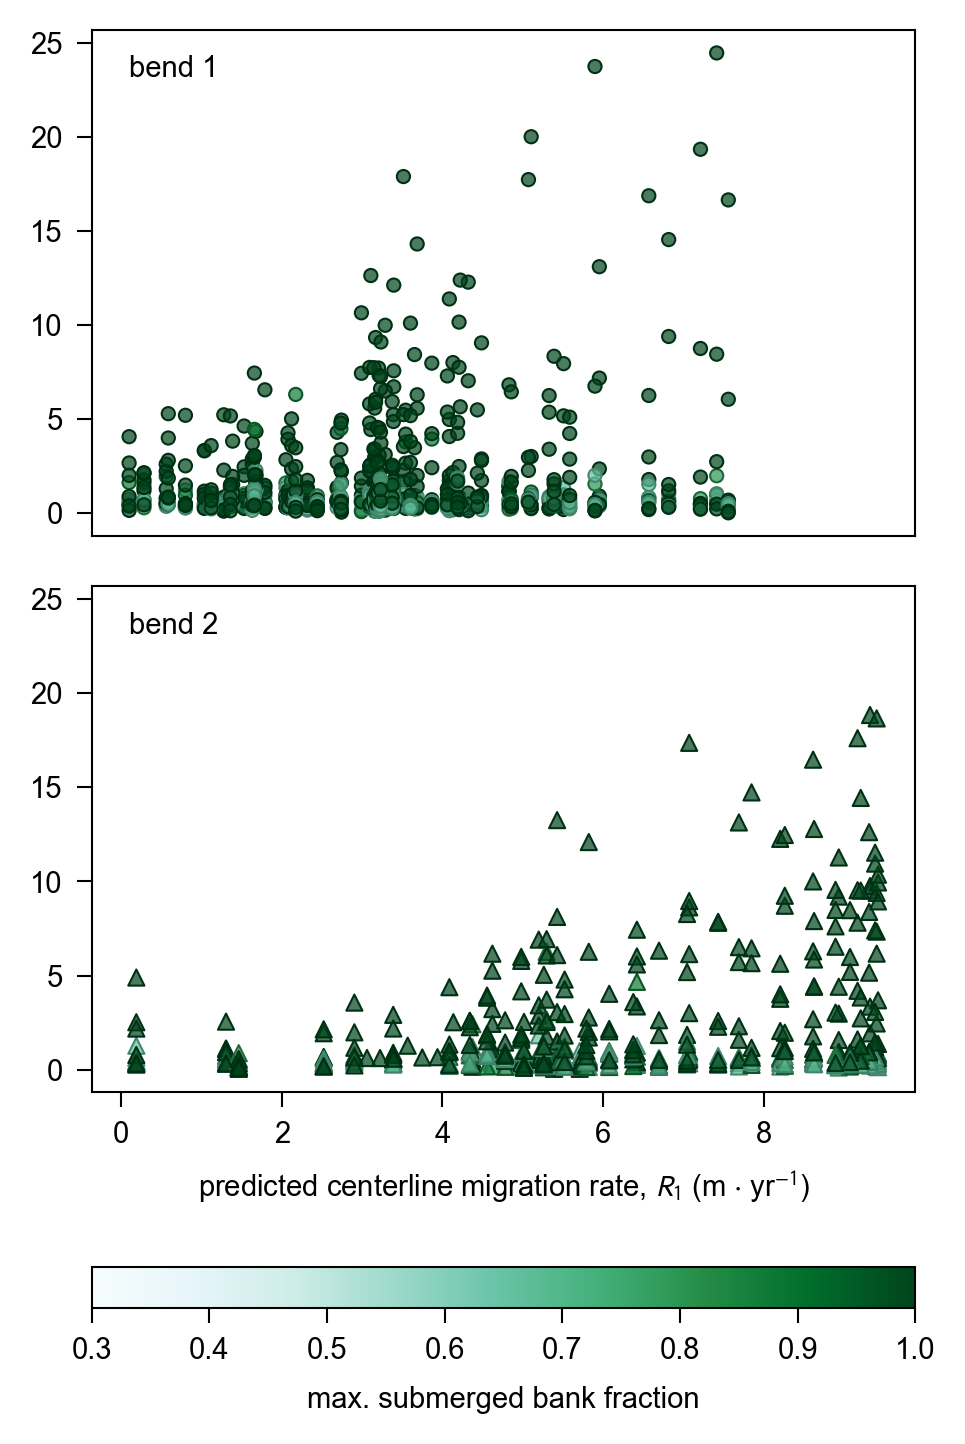

In [ ]:
colormap = cm.BuGn
norm = colors.Normalize(vmin=.3, vmax=1)

markers, sizes = ['o', '^'], [10, 15]
fig, axes = plt.subplots(2, 1, figsize=(9 * centimeters, 16 * centimeters), 
                        sharex=True, sharey=True, gridspec_kw={'hspace': 0.1})

for i, bend in enumerate([1, 2]):
    ax = axes[i]
    bend_data = curvature_erosion[curvature_erosion['bend'] == bend]
    face_colors = colormap(norm(bend_data['max_submerged_bank_percent'] / 100))
    face_colors[:, 3] = 0.7  # set face alpha to 0.7
    edge_colors = face_colors.copy()
    edge_colors[:, :3] *= 0.7  # darken rgb channels
    edge_colors[:, 3] = 1.0    # set edge alpha to 1
    
    ax.scatter(abs(bend_data['r1']), bend_data['mean_retreat_rate_m_yr'], 
              c=face_colors, marker=markers[i], edgecolors=edge_colors, 
              linewidths=0.5, s=sizes[i])
    ax.annotate(f'bend {bend}', xy=(0.1, 0.95), xycoords='axes fraction', 
           ha='center', va='top', fontsize=7)

axes[0].tick_params(bottom=False, labelbottom=False)
axes[-1].set_xlabel('predicted centerline migration rate, $R_{1}$ (m $\cdot$ yr$^{-1}$)', fontsize=7)
# axes[0].set_xticks(np.arange(1, 10, 2) * 1e-7)

sm = cm.ScalarMappable(norm=norm, cmap=colormap)
cbar = fig.colorbar(sm, ax=axes, shrink=1, orientation='horizontal', pad=0.12)
cbar.set_label('max. submerged bank fraction', fontsize=7)

fig.savefig('3_output-data/figures/r1_vs_area.pdf', bbox_inches='tight', pad_inches=0.05)

In [84]:
# from scipy import stats

correlation_results = []

for bend in [1, 2]:
    bend_data = curvature_erosion[curvature_erosion['bend'] == bend]
    for percent in flow_pairs['max_submerged_bank_percent'].unique():
        subset = bend_data[bend_data['max_submerged_bank_percent'] == percent]
        date = subset['alphashape_survey_date_1'].iloc[0]

        if len(subset) >= 3:
            valid_mask = ~(np.isnan(subset['r1']) | np.isnan(subset['area']))
            if valid_mask.sum() >= 3:
                r1_values = abs(subset.loc[valid_mask, 'r1'])
                area_values = subset.loc[valid_mask, 'area']

                rho, p_value = spearmanr(r1_values, area_values)
                

                # def statistic(x): # permute only `x`
                #     return stats.spearmanr(x, area_values).statistic

                # res_exact = stats.permutation_test((r1_values,), statistic,
                #     permutation_type='pairings')
                
                correlation_results.append({
                    'bend': bend,
                    'date': date,
                    'max_submerged_bank_percent': percent,
                    'spearman_rho_flow': rho,
                    'p_value_flow': p_value,
                    # 'permutation_p_value_flow': res_exact.pvalue,
                    'n_points_flow': len(r1_values)
                })

correlation_r1 = pd.DataFrame(correlation_results)
correlation_r1.head(20)

IndexError: single positional indexer is out-of-bounds

<>:24: SyntaxWarning: invalid escape sequence '\c'
<>:24: SyntaxWarning: invalid escape sequence '\c'
C:\Users\mn25983\AppData\Local\Temp\ipykernel_47024\2724579326.py:24: SyntaxWarning: invalid escape sequence '\c'
  axes[-1].set_xlabel('predicted centerline migration rate, $R_{1}$ (m $\cdot$ yr$^{-1}$)', fontsize=7)


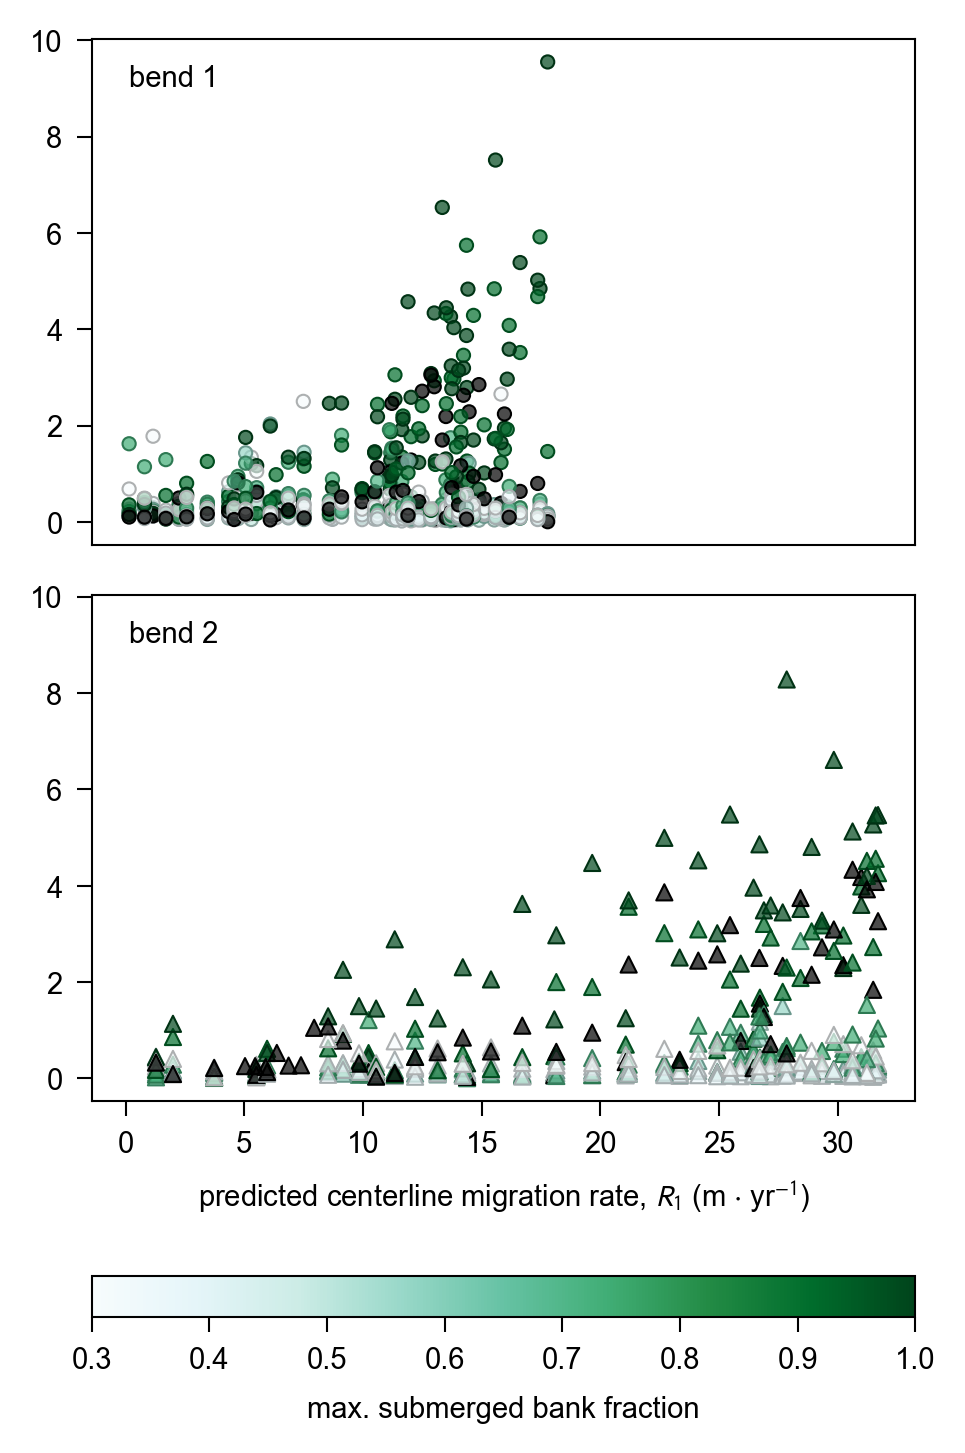

In [88]:
colormap = cm.BuGn
norm = colors.Normalize(vmin=.3, vmax=1)

markers, sizes = ['o', '^'], [10, 15]
fig, axes = plt.subplots(2, 1, figsize=(9 * centimeters, 16 * centimeters), 
                        sharex=True, sharey=True, gridspec_kw={'hspace': 0.1})

for i, bend in enumerate([1, 2]):
    ax = axes[i]
    bend_data = curvature_erosion[curvature_erosion['bend'] == bend]
    face_colors = colormap(norm(bend_data['max_submerged_bank_percent'] / 100))
    face_colors[:, 3] = 0.7  # set face alpha to 0.7
    edge_colors = face_colors.copy()
    edge_colors[:, :3] *= 0.7  # darken rgb channels
    edge_colors[:, 3] = 1.0    # set edge alpha to 1

    ax.scatter(abs(bend_data['r1'] * 365 * 24 * 60 * 60), bend_data['area'] / 5.5, 
              c=face_colors, marker=markers[i], edgecolors=edge_colors, 
              linewidths=0.5, s=sizes[i])
    ax.annotate(f'bend {bend}', xy=(0.1, 0.95), xycoords='axes fraction', 
           ha='center', va='top', fontsize=7)

axes[0].tick_params(bottom=False, labelbottom=False)
axes[-1].set_xlabel('predicted centerline migration rate, $R_{1}$ (m $\cdot$ yr$^{-1}$)', fontsize=7)
# axes[0].set_xticks(np.arange(1, 10, 2) * 1e-7)

sm = cm.ScalarMappable(norm=norm, cmap=colormap)
cbar = fig.colorbar(sm, ax=axes, shrink=1, orientation='horizontal', pad=0.12)
cbar.set_label('max. submerged bank fraction', fontsize=7)

<>:24: SyntaxWarning: invalid escape sequence '\c'
<>:24: SyntaxWarning: invalid escape sequence '\c'
C:\Users\mn25983\AppData\Local\Temp\ipykernel_47024\3849779633.py:24: SyntaxWarning: invalid escape sequence '\c'
  axes[-1].set_xlabel('predicted centerline migration rate, $R_{1}$ (m $\cdot$ s$^{-1}$)', fontsize=7)


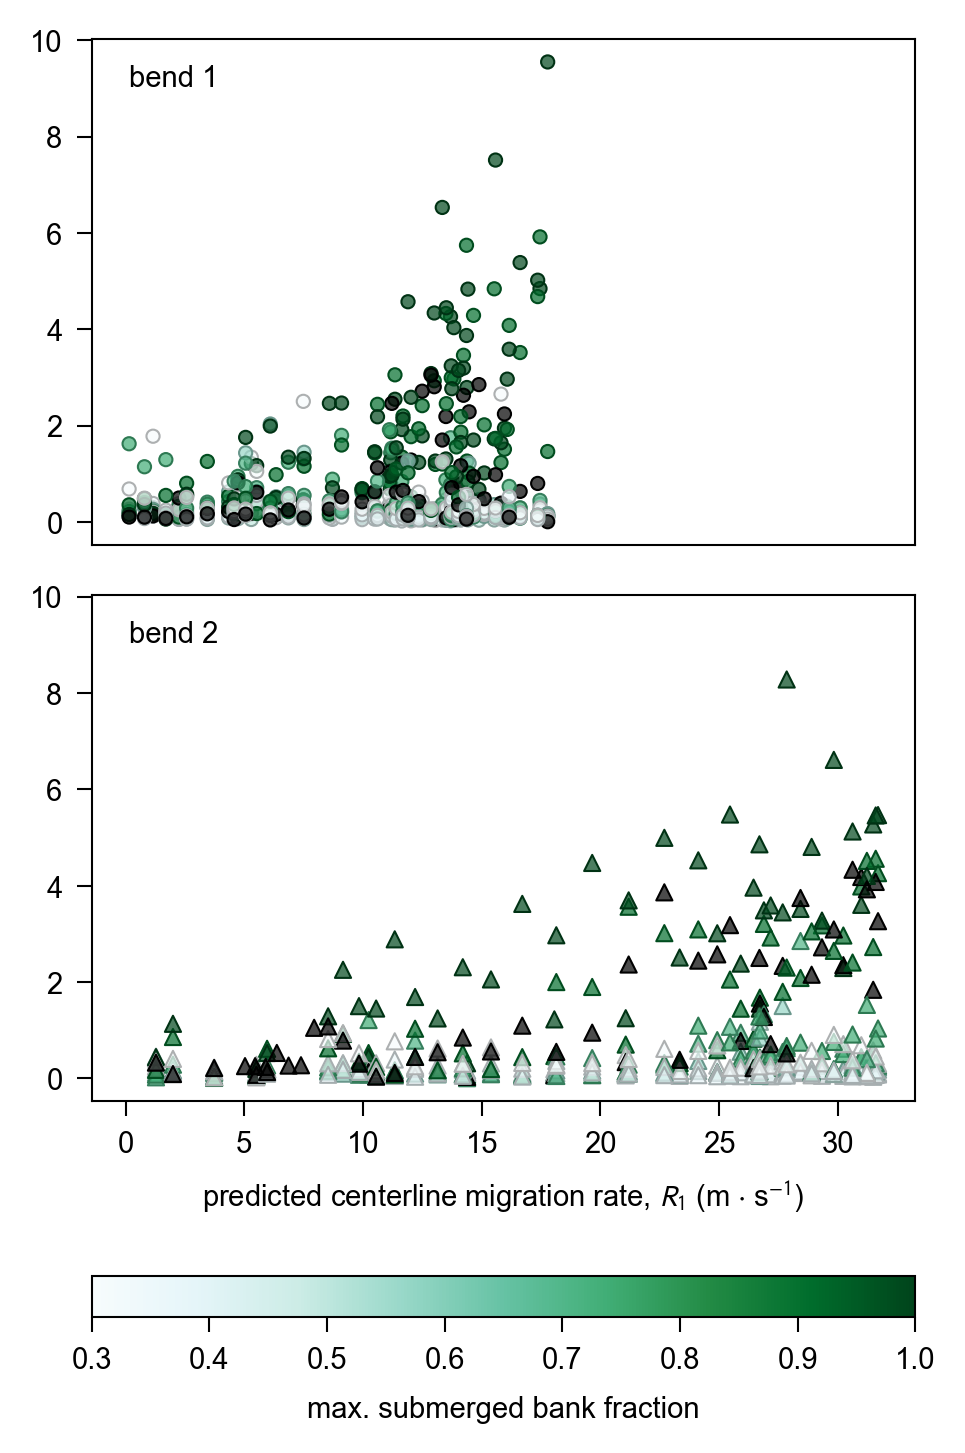

In [85]:
colormap = cm.BuGn
norm = colors.Normalize(vmin=.3, vmax=1)

markers, sizes = ['o', '^'], [10, 15]
fig, axes = plt.subplots(2, 1, figsize=(9 * centimeters, 16 * centimeters), 
                        sharex=True, sharey=True, gridspec_kw={'hspace': 0.1})

for i, bend in enumerate([1, 2]):
    ax = axes[i]
    bend_data = curvature_erosion[curvature_erosion['bend'] == bend]
    face_colors = colormap(norm(bend_data['max_submerged_bank_percent'] / 100))
    face_colors[:, 3] = 0.7  # set face alpha to 0.7
    edge_colors = face_colors.copy()
    edge_colors[:, :3] *= 0.7  # darken rgb channels
    edge_colors[:, 3] = 1.0    # set edge alpha to 1

    ax.scatter(abs(bend_data['r1'] * 365 * 24 * 60 * 60), bend_data['area'] / 5.5, 
              c=face_colors, marker=markers[i], edgecolors=edge_colors, 
              linewidths=0.5, s=sizes[i])
    ax.annotate(f'bend {bend}', xy=(0.1, 0.95), xycoords='axes fraction', 
           ha='center', va='top', fontsize=7)

axes[0].tick_params(bottom=False, labelbottom=False)
axes[-1].set_xlabel('predicted centerline migration rate, $R_{1}$ (m $\cdot$ s$^{-1}$)', fontsize=7)
# axes[0].set_xticks(np.arange(1, 10, 2) * 1e-7)

sm = cm.ScalarMappable(norm=norm, cmap=colormap)
cbar = fig.colorbar(sm, ax=axes, shrink=1, orientation='horizontal', pad=0.12)
cbar.set_label('max. submerged bank fraction', fontsize=7)

# fig.savefig('r1_vs_area.pdf', bbox_inches='tight', pad_inches=0.05)

In [86]:
from scipy import stats

correlation_results = []

for bend in [1, 2]:
    bend_data = curvature_erosion[curvature_erosion['bend'] == bend]
    for percent in flow_pairs['max_submerged_bank_percent'].unique():
        subset = bend_data[bend_data['max_submerged_bank_percent'] == percent]
        date = subset['alphashape_survey_date_1'].iloc[0]

        if len(subset) >= 3:
            valid_mask = ~(np.isnan(subset['r1']) | np.isnan(subset['area']))
            if valid_mask.sum() >= 3:
                r1_values = abs(subset.loc[valid_mask, 'r1']) * 365 * 24 * 60 * 60
                area_values = subset.loc[valid_mask, 'area'] / 5.5
                area_mean = area_values.mean()

                rho, p_value = spearmanr(r1_values, area_values)
                
                slope, intercept, r_value, p_value, std_err = stats.linregress(r1_values, area_values)
                r_squared = r_value**2

                # Method 2: Calculate residuals and their statistics
                y_pred = slope * r1_values + intercept
                residuals = area_values - y_pred
                rmse = np.sqrt(np.mean(residuals**2))
                mae = np.mean(np.abs(residuals))

                # Method 3: Confidence intervals for the regression line
                # Calculate standard error of prediction
                n = len(r1_values)
                x_mean = np.mean(r1_values)
                sxx = np.sum((r1_values - x_mean)**2)
                s_yx = np.sqrt(np.sum(residuals**2) / (n - 2))  # residual standard error

                # Standard error of prediction at each point
                se_pred = s_yx * np.sqrt(1 + 1/n + (r1_values - x_mean)**2 / sxx)

                # 95% confidence intervals
                t_val = stats.t.ppf(0.975, n-2)  # 95% confidence interval
                ci_lower = y_pred - t_val * se_pred
                ci_upper = y_pred + t_val * se_pred

                # Store results
                correlation_results.append({
                    'bend': bend,
                    'date': date,
                    'area_mean': area_mean,
                    'max_submerged_bank_percent': percent,
                    'slope': slope,
                    'intercept': intercept,
                    'r_squared': r_squared,
                    # 'p_value': p_value,
                    'std_err': std_err,
                    'rmse': rmse,
                    'mae': mae,
                    'mean_ci_width': np.mean(ci_upper - ci_lower),
                    'n_points': len(r1_values)
                })
                # def statistic(x): # permute only `x`
                #     return stats.spearmanr(x, area_values).statistic

                # res_exact = stats.permutation_test((r1_values,), statistic,
                #     permutation_type='pairings')
                
                # correlation_results.append({
                #     'bend': bend,
                #     'date': date,
                #     'max_submerged_bank_percent': percent,
                #     'spearman_rho_flow': rho,
                #     'p_value_flow': p_value,
                #     # 'permutation_p_value_flow': res_exact.pvalue,
                #     'n_points_flow': len(r1_values)
                # })

correlation_r1 = pd.DataFrame(correlation_results)
correlation_r1.head(20)

IndexError: single positional indexer is out-of-bounds

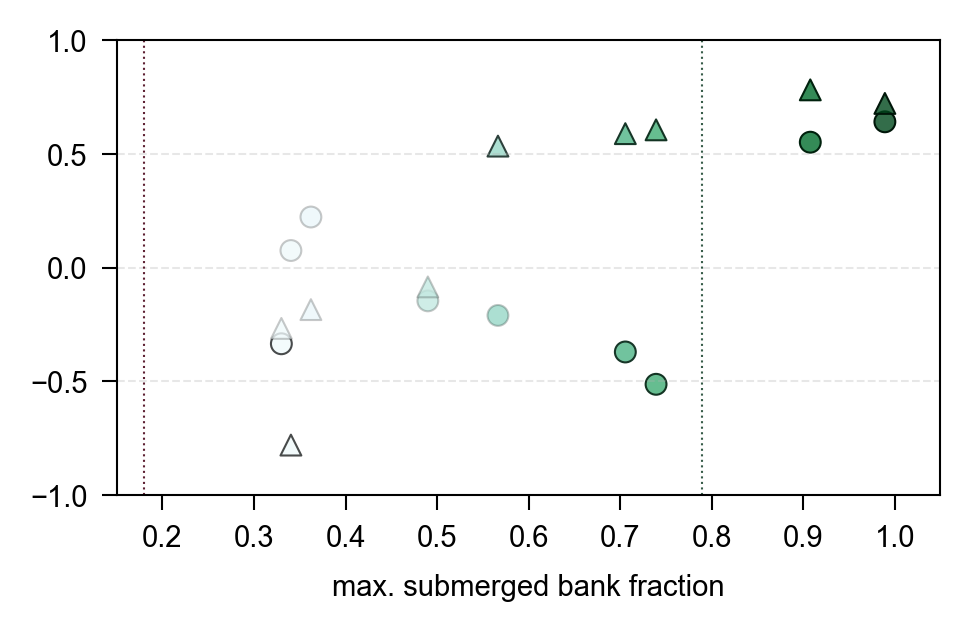

In [29]:
fig, ax = plt.subplots(figsize=(9 * centimeters, 5 * centimeters))

markers= ['o', '^']
cmap = plt.cm.BuGn
norm = colors.Normalize(vmin=30, vmax=100)

for i, bend in enumerate([1, 2]):
    subset = correlation_r1[correlation_r1['bend'] == bend]
    
    face_colors = cmap(norm(subset['max_submerged_bank_percent']))
    edge_colors = face_colors.copy()
    edge_colors[:, :3] *= 0.3  # darken rgb channels
    edge_colors[:, 3] = 1.0    # set edge alpha to 1
    edge_colors[:, 3] = np.where(subset['p_value_flow'] > 0.01, 0.3, 1.0)
    face_colors[:, 3] = np.where(subset['p_value_flow'] > 0.01, 0.8, 0.8)
    
    ax.scatter(subset['max_submerged_bank_percent'] / 100, subset['spearman_rho_flow'], 
               c=face_colors, marker=markers[i], 
               edgecolors=edge_colors, linewidths=0.5, s=25)

median_stage = .18
p90_stage = .79

ax.axvline(median_stage, color='#5E2133', linestyle=':', lw=0.5)
# ax.annotate('50p stage', xy=(0.2, 0.1), xytext=(.2, 0.85), textcoords='data', fontsize=7, color='#5E2133')
ax.axvline(p90_stage, color='#375C49', linestyle=':', lw=0.5)
# ax.annotate('90p stage', xy=(0.2, 0.1), xytext=(.81, 0.85), textcoords='data', fontsize=7, color='#375C49')

ax.set_xlabel('max. submerged bank fraction')
# ax.set_ylabel('Spearman\'s $\\rho$')
ax.set_ylim(-1, 1)
ax.set_xlim(.15, 1.05)
ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.3)

fig.savefig('spearman_r1.pdf', bbox_inches='tight', pad_inches=0.05)

#### bin by r1

<>:29: SyntaxWarning: invalid escape sequence '\c'
<>:29: SyntaxWarning: invalid escape sequence '\c'
/var/folders/_x/bz5s4nqd5zvby6hjph5wbp1w0000gn/T/ipykernel_39936/1690949934.py:29: SyntaxWarning: invalid escape sequence '\c'
  cbar.set_label('predicted centerline migration rate, $R_{1}$ (m $\cdot$ s$^{-1}$)')


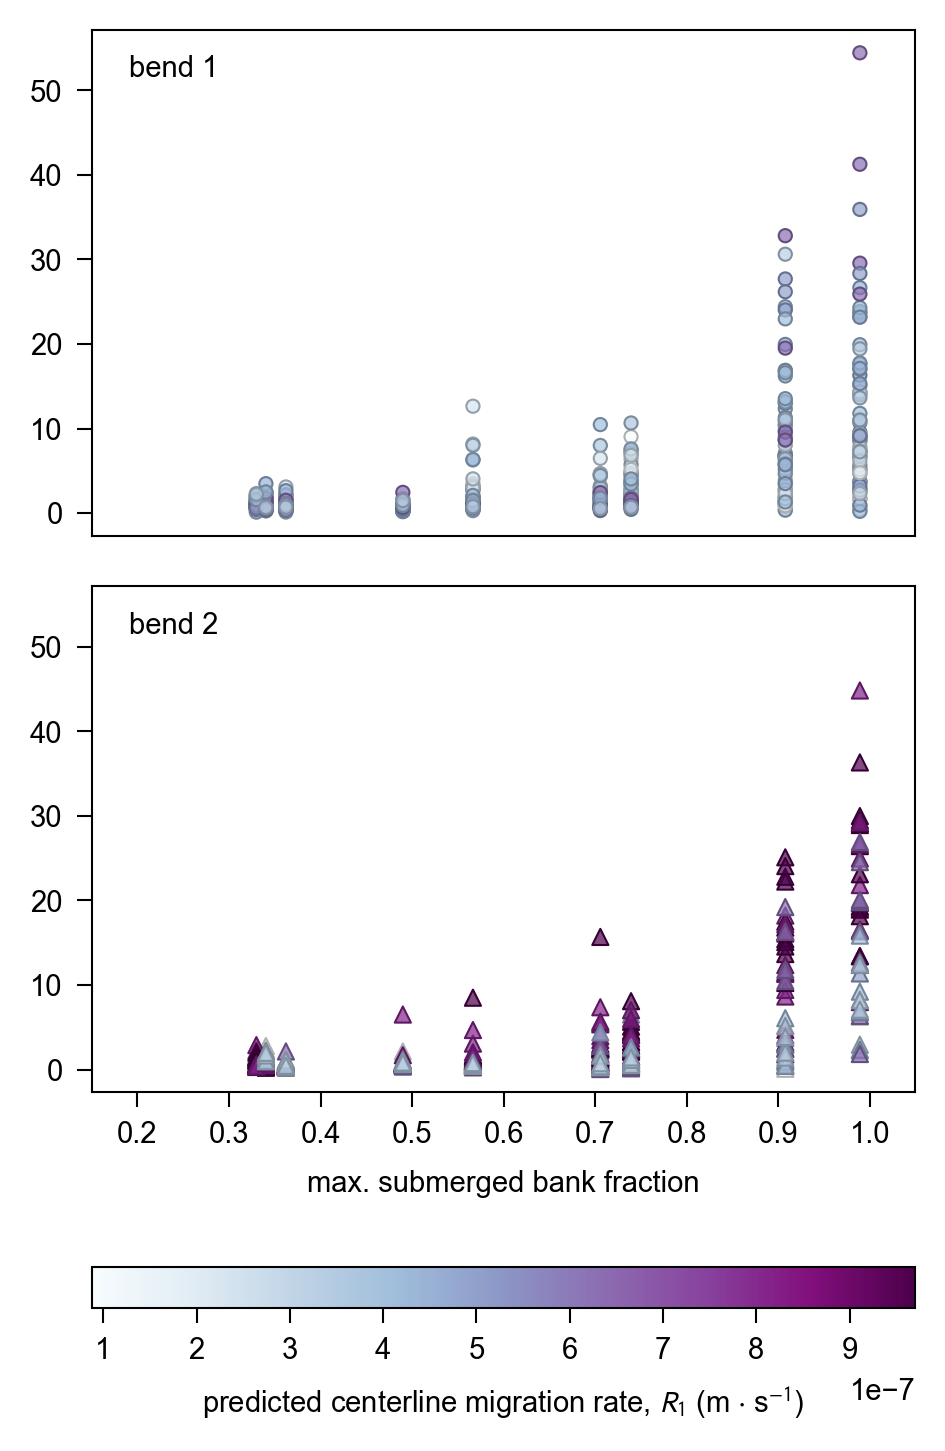

In [30]:
colormap = cm.BuPu
norm = colors.Normalize(vmin=curvature_erosion['r1_bin'].min(), vmax=curvature_erosion['r1_bin'].max())

markers, sizes = ['o', '^'], [10, 15]
fig, axes = plt.subplots(2, 1, figsize=(9 * centimeters, 16 * centimeters), 
                        sharex=True, sharey=True, gridspec_kw={'hspace': 0.1})

for i, bend in enumerate([1, 2]):
    ax = axes[i]
    bend_data = curvature_erosion[curvature_erosion['bend'] == bend]
    face_colors = colormap(norm(bend_data['r1_bin']))
    face_colors[:, 3] = 0.7  # set face alpha to 0.7
    edge_colors = face_colors.copy()
    edge_colors[:, :3] *= 0.7  # darken rgb channels
    edge_colors[:, 3] = 1.0    # set edge alpha to 1
    
    ax.scatter(bend_data['max_submerged_bank_percent'] / 100, bend_data['area'], 
              c=face_colors, marker=markers[i], edgecolors=edge_colors, 
              linewidths=0.5, s=sizes[i])
    ax.annotate(f'bend {bend}', xy=(0.1, 0.95), xycoords='axes fraction', 
           ha='center', va='top', fontsize=7)

axes[0].tick_params(bottom=False, labelbottom=False)
axes[-1].set_xlabel('max. submerged bank fraction')
axes[-1].set_xlim(.15, 1.05)

sm = cm.ScalarMappable(norm=norm, cmap=colormap)
cbar = fig.colorbar(sm, ax=axes, shrink=1, orientation='horizontal', pad=0.12)
cbar.set_label('predicted centerline migration rate, $R_{1}$ (m $\cdot$ s$^{-1}$)')

fig.savefig('max_submerged_bank_vs_area.pdf', bbox_inches='tight', pad_inches=0.05)

In [45]:
correlation_results = []

for bend in [1, 2]:
    bend_data = curvature_erosion[curvature_erosion['bend'] == bend]
    for r1 in curvature_erosion['r1_bin'].unique():
        subset = bend_data[bend_data['r1_bin'] == r1]

        if len(subset) >= 3:
            valid_mask = ~(np.isnan(subset['max_submerged_bank_percent']) | np.isnan(subset['area']))
            if valid_mask.sum() >= 3:
                flow_values = abs(subset.loc[valid_mask, 'max_submerged_bank_percent'])
                area_values = subset.loc[valid_mask, 'area']

                rho, p_value = spearmanr(flow_values, area_values)

                correlation_results.append({
                    'bend': bend,
                    'r1_bin': r1,
                    'spearman_rho_r1': rho,
                    'p_value_r1': p_value,
                    'n_points_r1': len(flow_values)
                })

correlation_flow = pd.DataFrame(correlation_results)
correlation_flow.sort_values(by=['bend', 'r1_bin'])

,bend,r1_bin,spearman_rho_r1,p_value_r1,n_points_r1
0,1,8.755093e-08,0.313503,4.373412e-03,81
1,1,2.321258e-07,0.591518,8.303549e-10,90
2,1,3.264616e-07,0.631892,3.634340e-08,62
3,1,3.745020e-07,0.678481,2.017585e-13,90
4,1,4.059988e-07,0.495697,1.820097e-07,99
5,1,4.425660e-07,0.520869,6.197425e-07,81
6,1,4.949811e-07,0.577006,2.116325e-08,80
7,1,6.273199e-07,0.608942,8.112138e-05,36
8,2,8.755093e-08,-0.102116,6.196229e-01,26
9,2,2.321258e-07,-0.785714,2.081513e-02,8


<>:21: SyntaxWarning: invalid escape sequence '\c'
<>:21: SyntaxWarning: invalid escape sequence '\c'
/var/folders/_x/bz5s4nqd5zvby6hjph5wbp1w0000gn/T/ipykernel_39936/3007319283.py:21: SyntaxWarning: invalid escape sequence '\c'
  ax.set_xlabel('predicted centerline migration rate, $R_{1}$ (m $\cdot$ s$^{-1}$)')


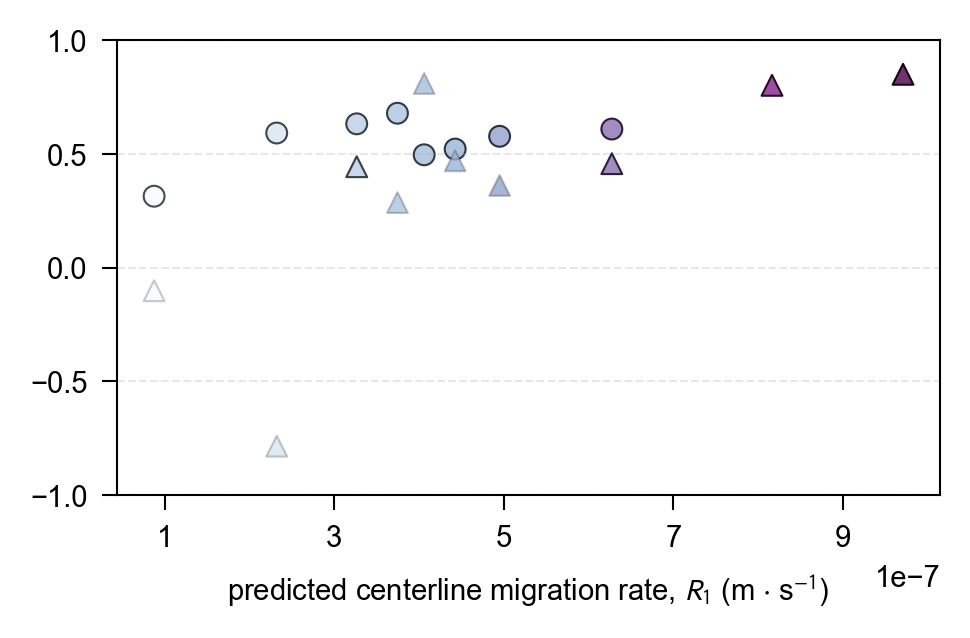

In [32]:
fig, ax = plt.subplots(figsize=(9 * centimeters, 5 * centimeters))

markers = ['o', '^']
cmap = plt.cm.BuPu
norm = colors.Normalize(vmin=correlation_flow['r1_bin'].min(), vmax=correlation_flow['r1_bin'].max())

for i, bend in enumerate([1, 2]):
    subset = correlation_flow[correlation_flow['bend'] == bend]
    
    face_colors = cmap(norm(subset['r1_bin']))
    edge_colors = face_colors.copy()
    edge_colors[:, :3] *= 0.3  # darken rgb channels
    edge_colors[:, 3] = 1.0    # set edge alpha to 1
    edge_colors[:, 3] = np.where(subset['p_value_r1'] > 0.01, 0.3, 1.0)
    face_colors[:, 3] = np.where(subset['p_value_r1'] > 0.01, 0.8, 0.8)
    
    ax.scatter(subset['r1_bin'], subset['spearman_rho_r1'], 
               c=face_colors, marker=markers[i], 
               edgecolors=edge_colors, linewidths=0.5, s=25)

ax.set_xlabel('predicted centerline migration rate, $R_{1}$ (m $\cdot$ s$^{-1}$)')
ax.set_xticks(np.arange(1, 10, 2) * 1e-7)
# ax.set_ylabel('Spearman\'s $\\rho$')
ax.set_ylim(-1, 1)
ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.3)

fig.savefig('spearman_flow.pdf', bbox_inches='tight', pad_inches=0.05)

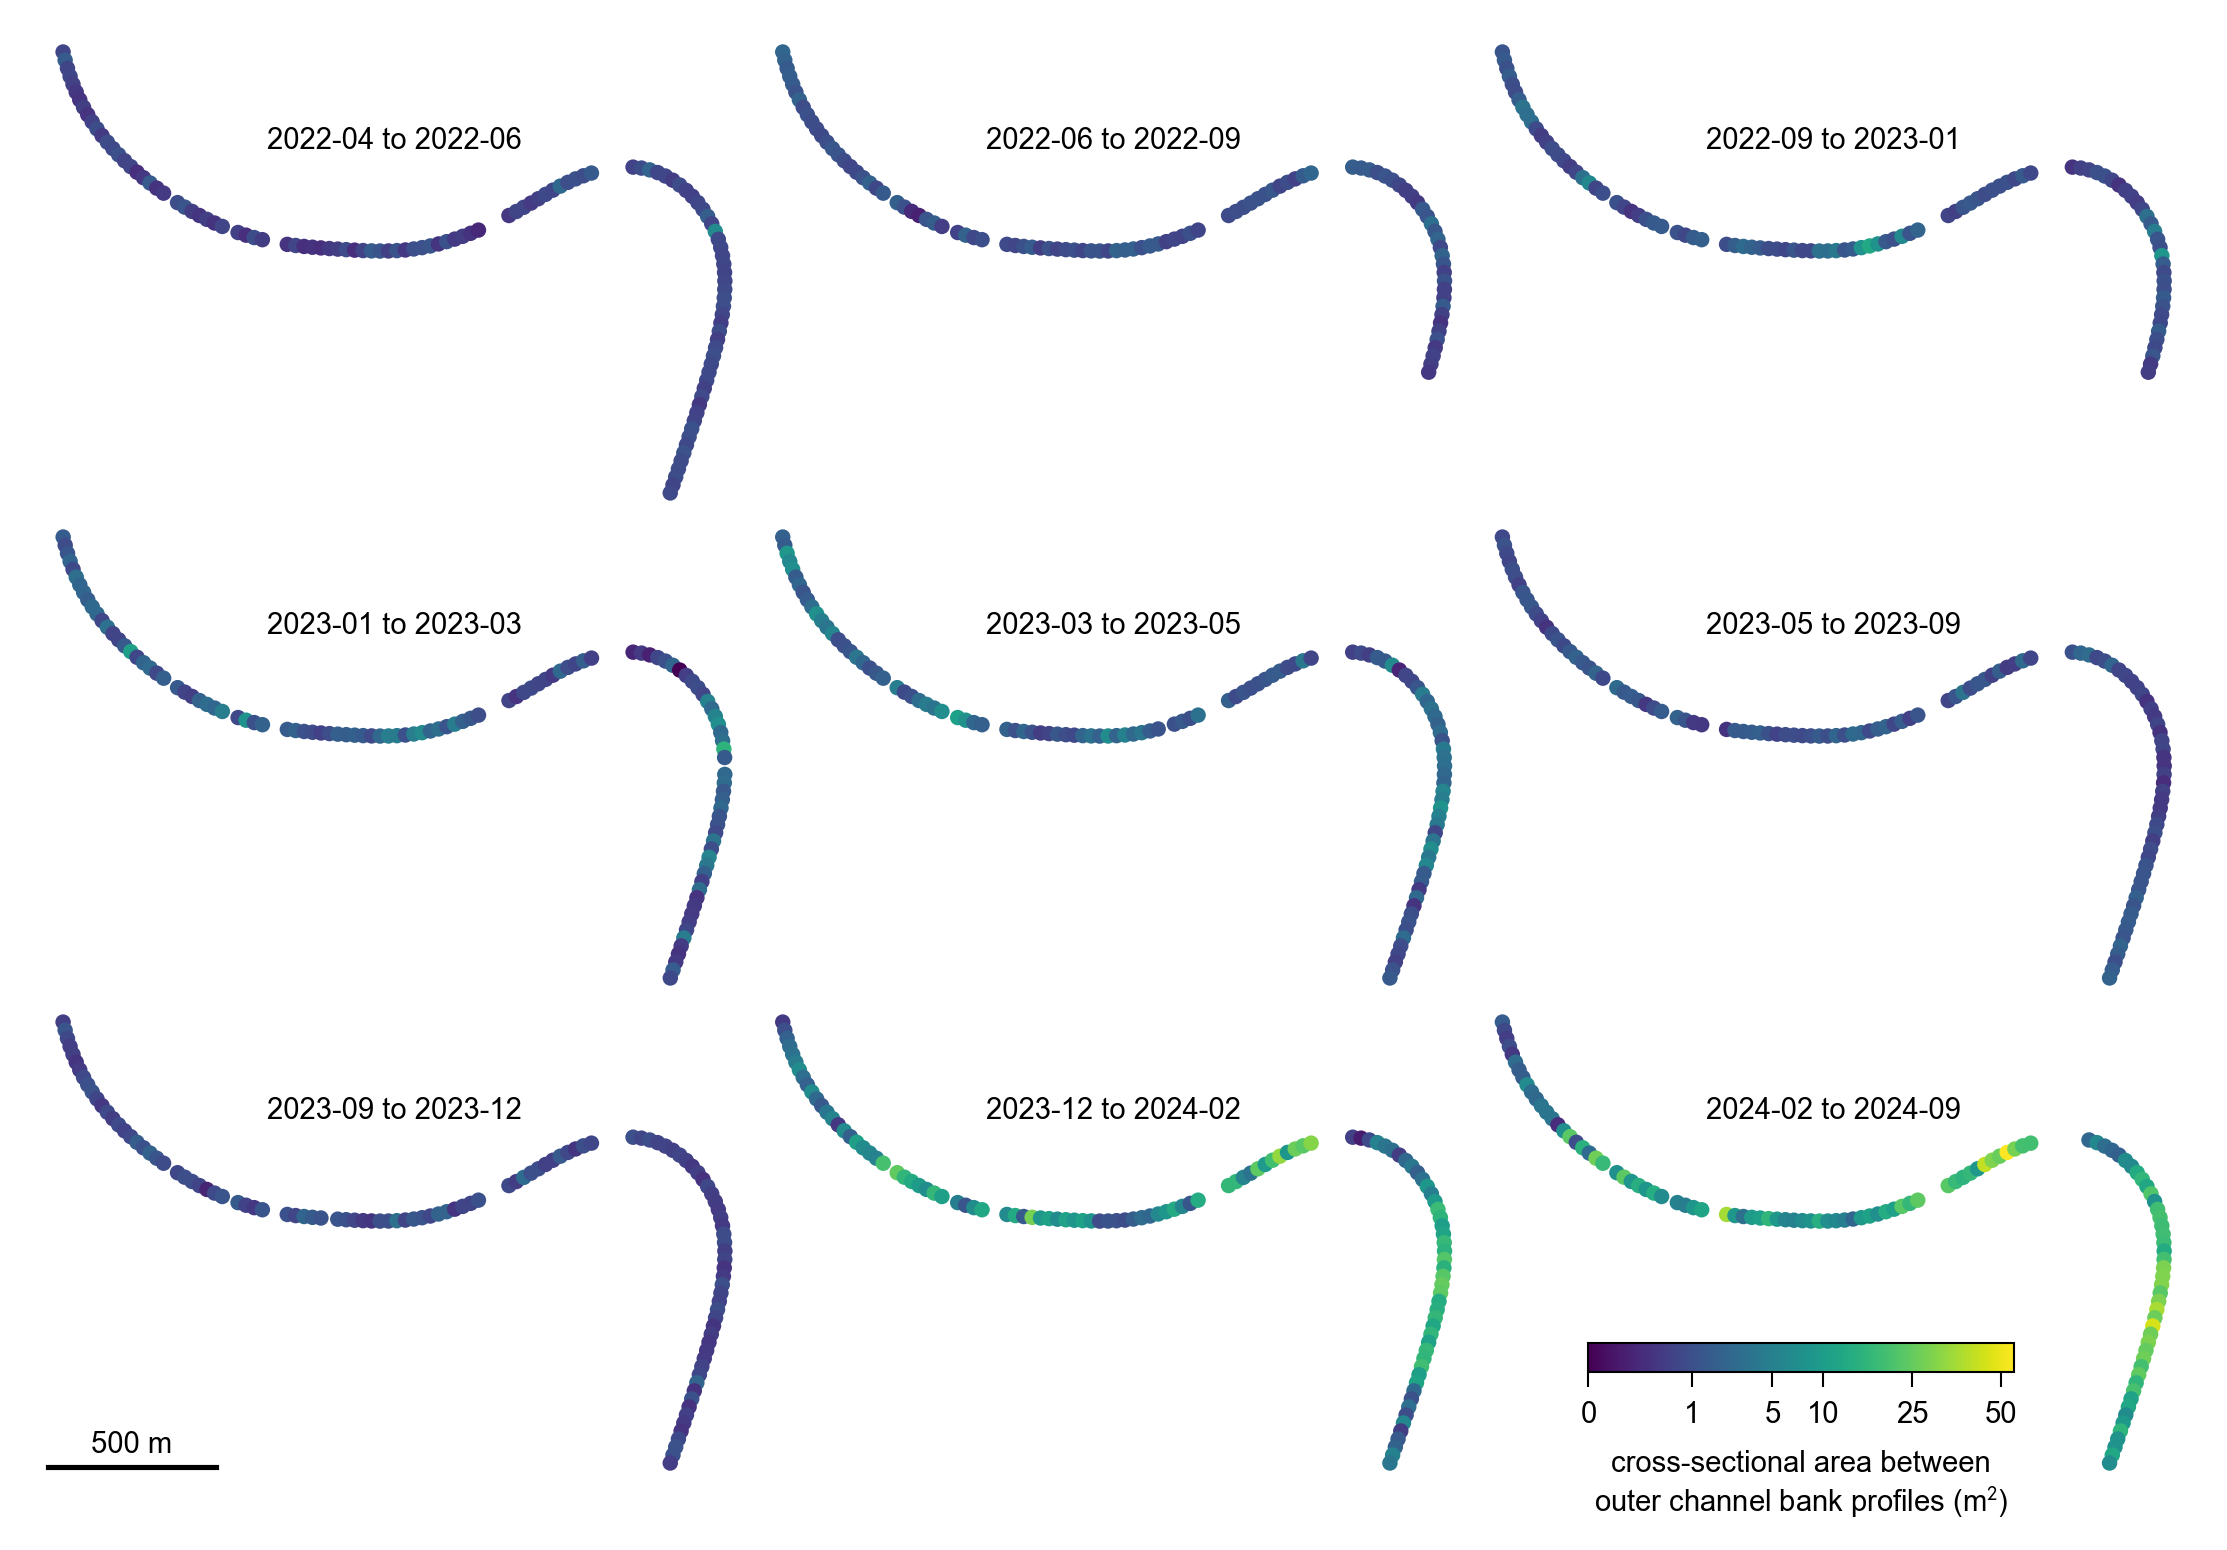

In [33]:
def plot_erosion_map_grid_consecutive_dates(alpha_metadata, all_dates):
    consecutive_pairs = [(all_dates[i], all_dates[i+1]) for i in range(len(all_dates)-1)]
    consecutive_metadata = alpha_metadata[
        alpha_metadata.apply(lambda row: (row['alphashape_survey_date_1'], row['alphashape_survey_date_2']) in consecutive_pairs, axis=1)]
    date_pairs = consecutive_metadata[['alphashape_survey_date_1', 'alphashape_survey_date_2']].drop_duplicates().sort_values('alphashape_survey_date_1').reset_index(drop=True)
    vmin, vmax = consecutive_metadata['area'].min(), consecutive_metadata['area'].max()

    fig, axes = plt.subplots(3, 3, figsize=(24 * centimeters, 16 * centimeters), 
                            gridspec_kw={'wspace': -0.05, 'hspace': 0})

    for i, (_, row) in enumerate(date_pairs.iterrows()):
        if i >= 9: break
        ax = axes[i // 3, i % 3]
        date1, date2 = row['alphashape_survey_date_1'], row['alphashape_survey_date_2']
        pair_data = consecutive_metadata[
            (consecutive_metadata['alphashape_survey_date_1'] == date1) &
            (consecutive_metadata['alphashape_survey_date_2'] == date2)]
        
        scatter = ax.scatter(pair_data['x'], pair_data['y'], c=pair_data['area'], 
                        cmap='viridis', norm=PowerNorm(gamma=0.35, vmin=vmin, vmax=vmax), 
                        s=55, alpha=1, lw=0, marker='.')
        date1_str, date2_str = pd.to_datetime(date1).strftime('%Y-%m'), pd.to_datetime(date2).strftime('%Y-%m')
        ax.text(0.5, 0.8, f'{date1_str} to {date2_str}', transform=ax.transAxes, 
                fontsize=7, va='top', ha='center')
        
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        [ax.spines[spine].set_visible(False) for spine in ['top', 'right', 'left', 'bottom']]
        ax.patch.set_alpha(0)
        ax.set_ylim((3337731.5667, 3339165.9293))
    
    for i in range(len(date_pairs), 9):
        axes[i // 3, i % 3].set_visible(False)
    scale_ax = axes[2, 0]
    scalebar = AnchoredSizeBar(axes[2, 0].transData, 500, '500 m', 
                              loc='lower left', pad=0.5, color='black', 
                              frameon=False, size_vertical=1, label_top=True)
    scale_ax.add_artist(scalebar)
    
    cbar_ax = fig.add_axes([0.68, 0.17, 0.15, 0.015])  # [left, bottom, width, height]
    cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('cross-sectional area between\nouter channel bank profiles (m$^{2}$)', fontsize=7, linespacing=1.3)
    cbar.ax.tick_params(labelsize=7)
    cbar.set_ticks([0, 1, 5, 10, 25, 50])
    
    fig.savefig('f4-erosion-maps/erosion_map_consecutive_dates.pdf', 
               bbox_inches='tight', pad_inches=0.05, dpi=600)
    plt.show()

plot_erosion_map_grid_consecutive_dates(curvature_erosion, all_dates)

In [34]:
def create_continuous_segments(data):
    # find breaks where transect_idx is not consecutive
    breaks = np.where(np.diff(data['transect_idx']) > 1)[0] + 1
    split_indices = np.concatenate([[0], breaks, [len(data)]])
    
    segments_list = []
    colors_list = []
    
    for i in range(len(split_indices) - 1):
        start, end = split_indices[i], split_indices[i + 1]
        if end - start > 1:  # need at least 2 points for segments
            segment_data = data.iloc[start:end]
            points = np.column_stack([segment_data['x'], segment_data['y']]).reshape(-1, 1, 2)
            segment_lines = np.concatenate([points[:-1], points[1:]], axis=1)
            segments_list.extend(segment_lines)
            colors_list.extend(segment_data['area'].iloc[:-1])
    
    return segments_list, colors_list

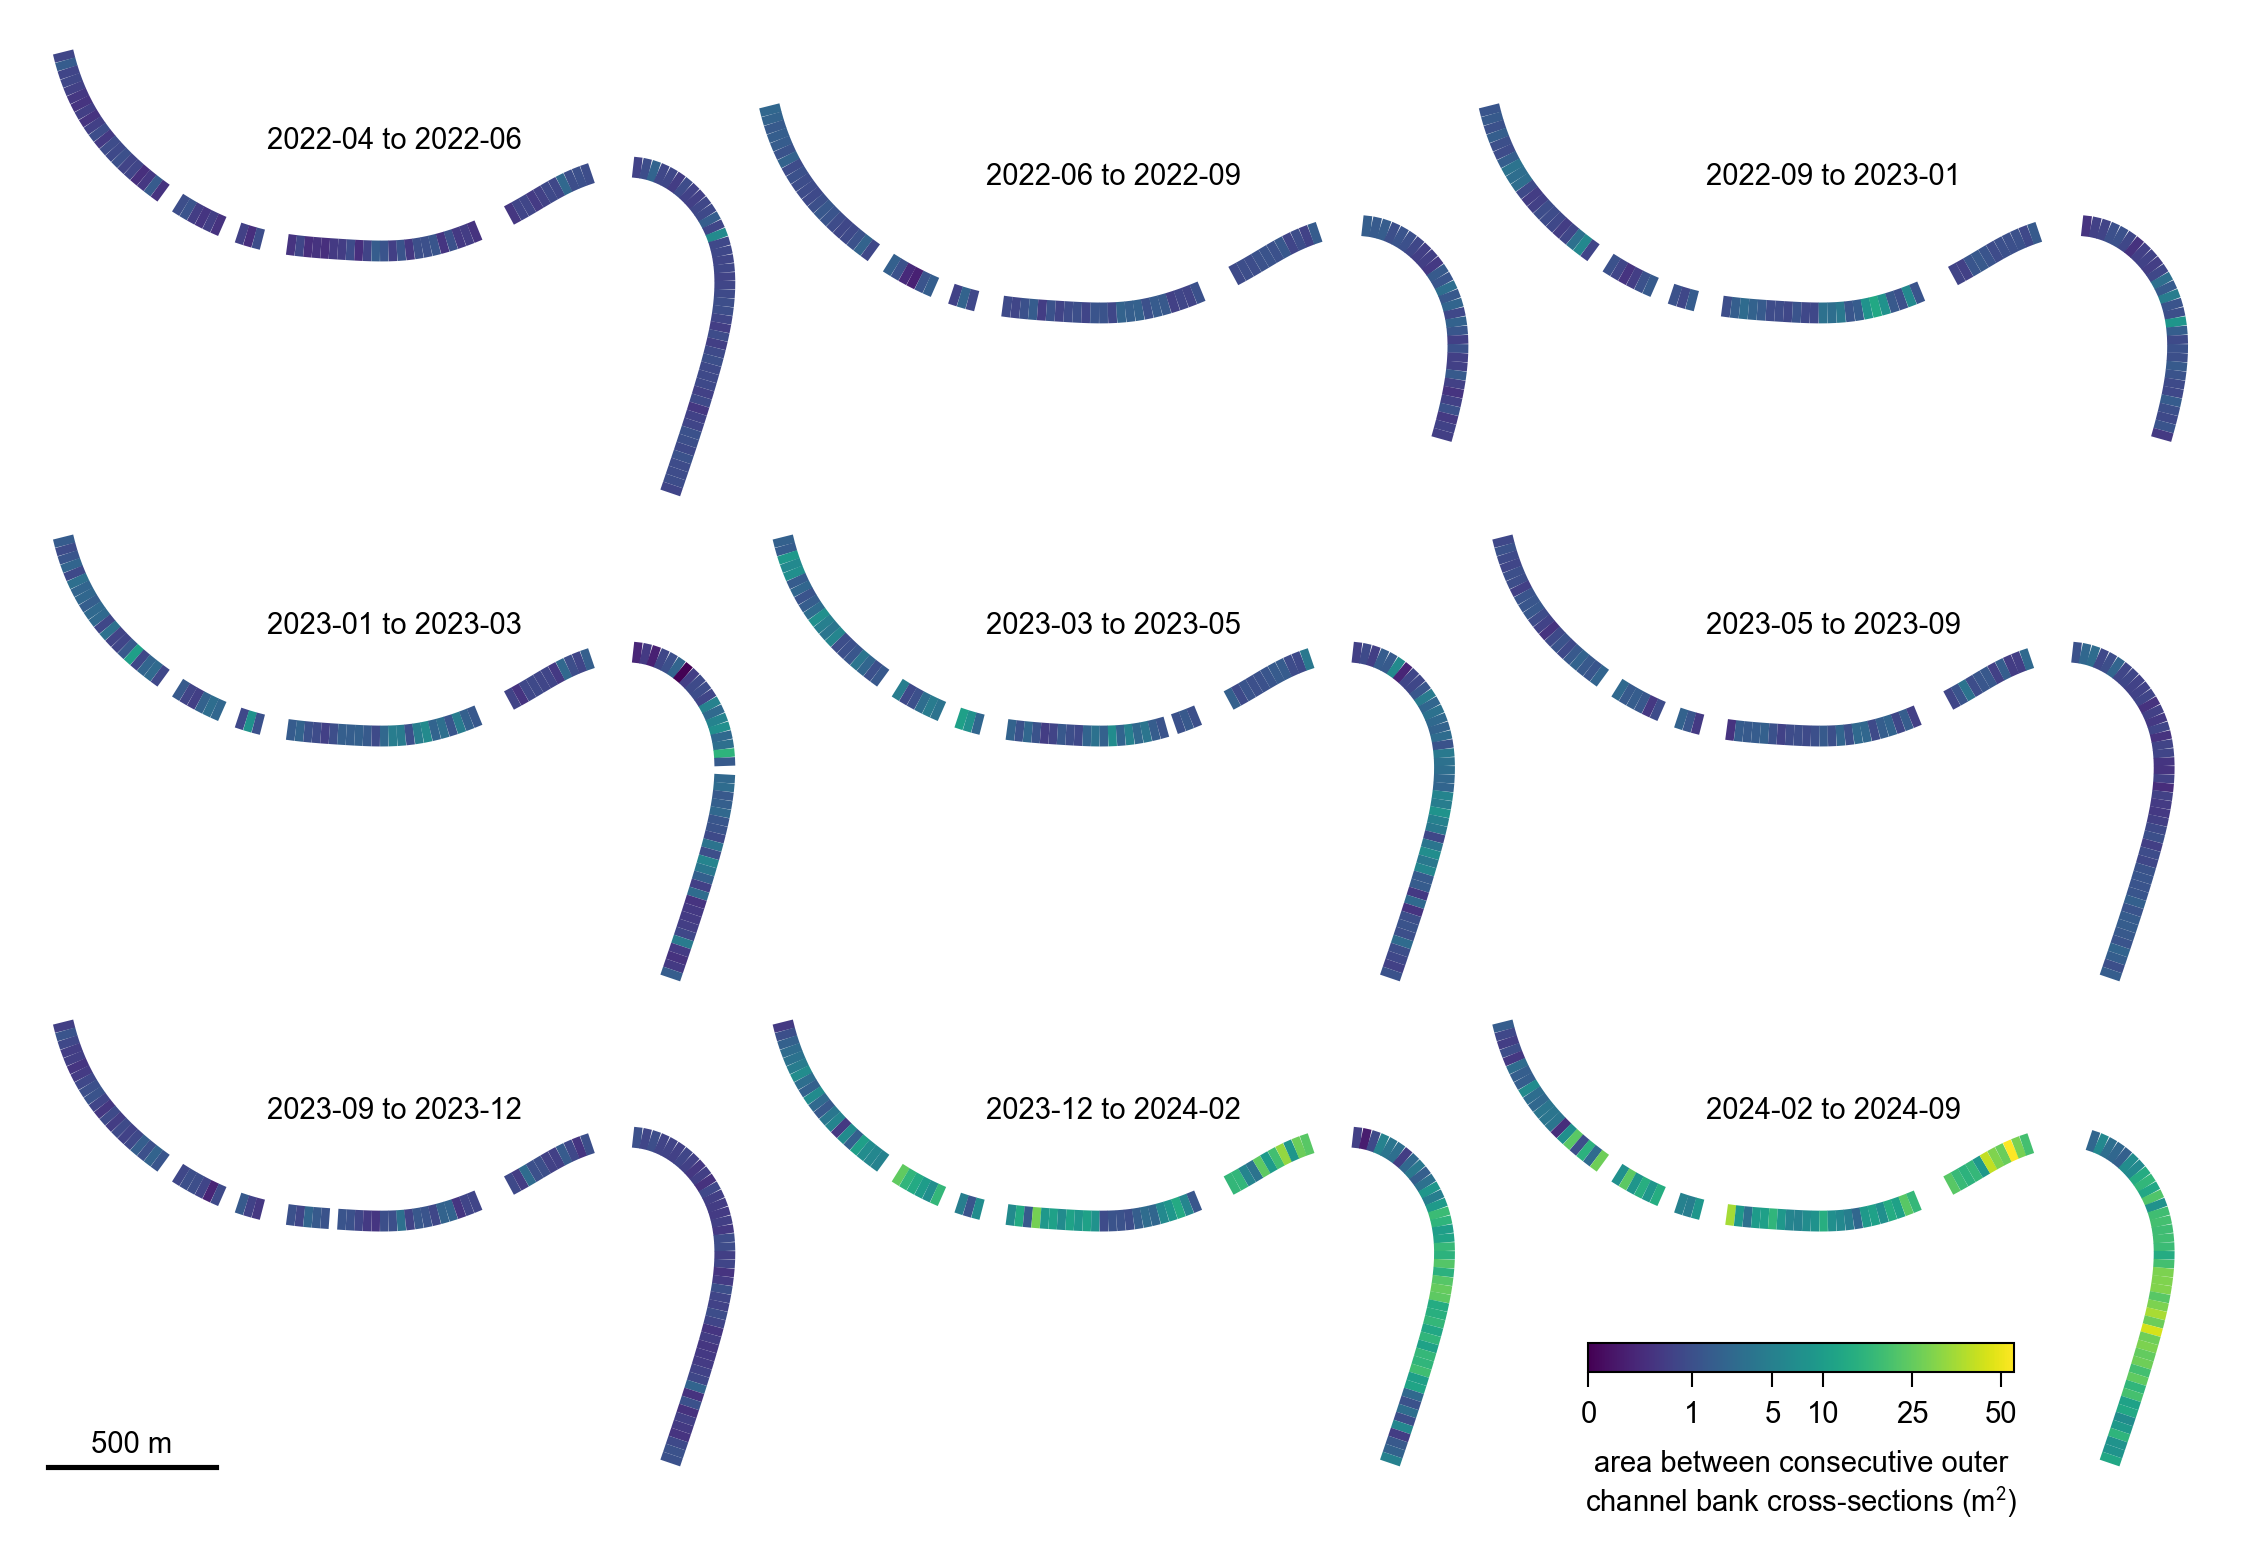

In [35]:
from matplotlib.collections import LineCollection

def plot_erosion_map_grid_consecutive_dates(alpha_metadata, all_dates):
    consecutive_pairs = [(all_dates[i], all_dates[i+1]) for i in range(len(all_dates)-1)]
    consecutive_metadata = alpha_metadata[
        alpha_metadata.apply(lambda row: (row['alphashape_survey_date_1'], row['alphashape_survey_date_2']) in consecutive_pairs, axis=1)]
    date_pairs = consecutive_metadata[['alphashape_survey_date_1', 'alphashape_survey_date_2']].drop_duplicates().sort_values('alphashape_survey_date_1').reset_index(drop=True)
    vmin, vmax = consecutive_metadata['area'].min(), consecutive_metadata['area'].max()

    fig, axes = plt.subplots(3, 3, figsize=(24 * centimeters, 16 * centimeters), 
                            gridspec_kw={'wspace': -0.05, 'hspace': 0})

    for i, (_, row) in enumerate(date_pairs.iterrows()):
        if i >= 9: break
        ax = axes[i // 3, i % 3]
        date1, date2 = row['alphashape_survey_date_1'], row['alphashape_survey_date_2']
        pair_data = consecutive_metadata[
            (consecutive_metadata['alphashape_survey_date_1'] == date1) &
            (consecutive_metadata['alphashape_survey_date_2'] == date2)]
        
        # create line segments for smooth color transitions
        points = np.array([pair_data['x'], pair_data['y']]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        segments, colors = create_continuous_segments(pair_data.sort_values('transect_idx'))

        if segments:
            lc = LineCollection(segments, cmap='viridis', 
                            norm=PowerNorm(gamma=0.35, vmin=vmin, vmax=vmax),
                            linewidths=5)
            lc.set_array(np.array(colors))
            line = ax.add_collection(lc)
        
        date1_str, date2_str = pd.to_datetime(date1).strftime('%Y-%m'), pd.to_datetime(date2).strftime('%Y-%m')
        ax.text(0.5, 0.8, f'{date1_str} to {date2_str}', transform=ax.transAxes, 
                fontsize=7, va='top', ha='center')
        
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        [ax.spines[spine].set_visible(False) for spine in ['top', 'right', 'left', 'bottom']]
        ax.patch.set_alpha(0)
        ax.set_ylim((3337731.5667, 3339165.9293))
        ax.autoscale()  # needed for linecollection
    
    for i in range(len(date_pairs), 9):
        axes[i // 3, i % 3].set_visible(False)
    
    scale_ax = axes[2, 0]
    scalebar = AnchoredSizeBar(axes[2, 0].transData, 500, '500 m', 
                              loc='lower left', pad=0.5, color='black', 
                              frameon=False, size_vertical=1, label_top=True)
    scale_ax.add_artist(scalebar)
    
    cbar_ax = fig.add_axes([0.68, 0.17, 0.15, 0.015])
    cbar = fig.colorbar(line, cax=cbar_ax, orientation='horizontal')  # use line instead of scatter
    cbar.set_label('area between consecutive outer\nchannel bank cross-sections (m$^{2}$)', fontsize=7, linespacing=1.3)
    cbar.ax.tick_params(labelsize=7)
    cbar.set_ticks([0, 1, 5, 10, 25, 50])
    
    fig.savefig('f4-erosion-maps/erosion_map_consecutive_dates.pdf', 
               bbox_inches='tight', pad_inches=0.05)
    plt.show()

plot_erosion_map_grid_consecutive_dates(curvature_erosion, all_dates)

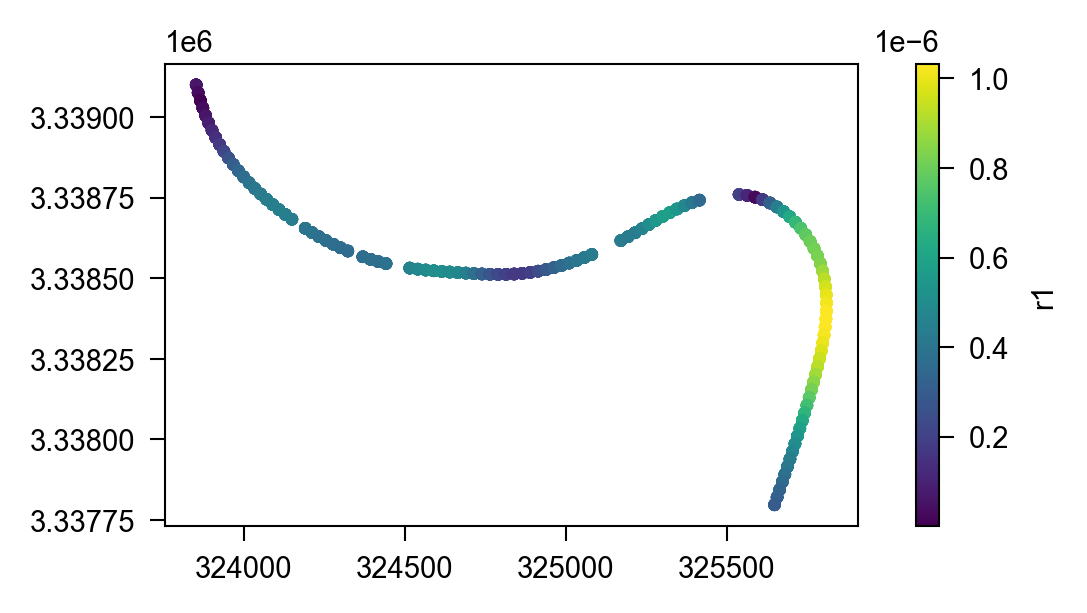

In [36]:
fig, ax = plt.subplots(figsize=(5, 2))
scatter = ax.scatter(curvature_erosion['x'], curvature_erosion['y'], c=abs(curvature_erosion['r1']), cmap='viridis', s=4)
ax.set_aspect('equal')
fig.colorbar(scatter, label='r1')

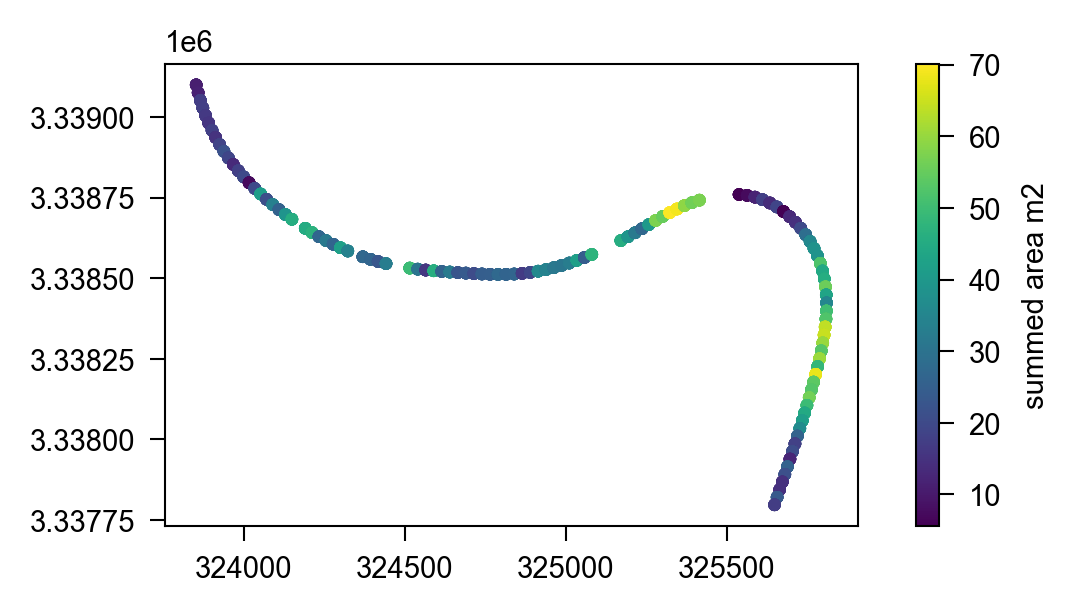

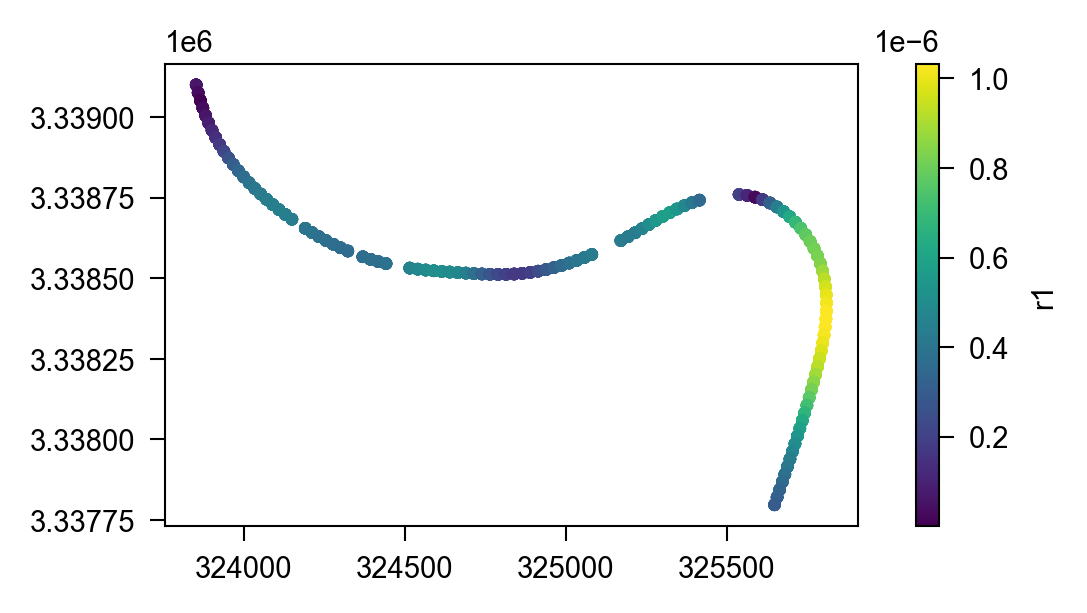

In [37]:
fig, ax = plt.subplots(figsize=(5, 2))
scatter = ax.scatter(curvature_erosion['x'], curvature_erosion['y'], c=curvature_erosion['summed_area'], cmap='viridis', s=4)
ax.set_aspect('equal')
fig.colorbar(scatter, label='summed area m2')

fig, ax = plt.subplots(figsize=(5, 2))
scatter = ax.scatter(curvature_erosion['x'], curvature_erosion['y'], c=abs(curvature_erosion['r1']), cmap='viridis', s=4)
ax.set_aspect('equal')
fig.colorbar(scatter, label='r1')

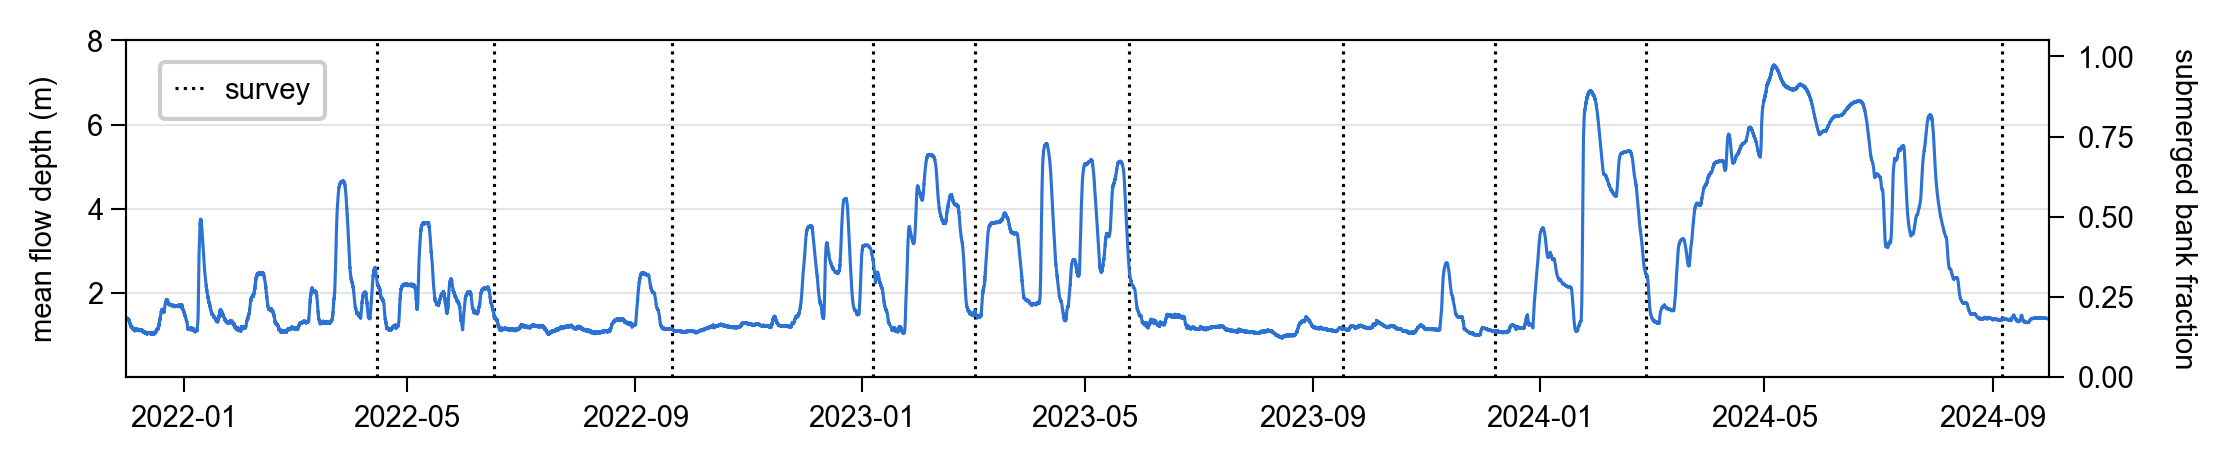

In [38]:
fig, ax1 = plt.subplots(figsize=(21 * centimeters, 3.7 * centimeters))

ax1.plot(flow['timestamp'], flow['crr_stage_above_bed_m'], linestyle='-', c='#2C72D5', lw=0.75, zorder=10)

ax4 = ax1.twinx()
# ax4.plot(flow['timestamp'], flow['submerged_bank_perc'] / 100, linestyle='-', c='cornflowerblue', lw=0.75, alpha=1, zorder=1)
area_timestamps = all_dates

for i, timestamp in enumerate(area_timestamps):
    label = 'survey' if i == 0 else ''
    ax1.axvline(timestamp, color='k', lw=0.75, ls=':', zorder=0, label=label)

ax1.legend(loc='upper left', frameon=True, facecolor='white', framealpha=1, bbox_to_anchor=(0.01, 0.98), handlelength=1, handletextpad=0.7, borderpad=0.5)

ax1.set_ylabel('mean flow depth (m)', labelpad=7)
ax4.set_ylabel('submerged bank fraction', labelpad=15, rotation=270, alpha=1, linespacing=1.6)
ax1.set_ylim(0.5, 8)
ax1.set_xlim([pd.Timestamp('2021-12-01'), pd.Timestamp('2024-10-01')])
ax1.tick_params('x', bottom=True, labelbottom=True, top=False, labeltop=False, pad=3)
ax1.tick_params('y', pad=2)

ax4.set_ylim(0, 1.05)
ax1.set_yticks([2, 4, 6, 8])
minor_ticks_y = np.arange(0, 8, 2)
ax1.set_yticks(minor_ticks_y, minor=True)
ax1.tick_params('y', which='minor', top=False, bottom=False, labeltop=False, labelbottom=False, length=0)
ax1.yaxis.grid(True, which='both', linewidth=0.5, c='k', alpha=0.1)

fig.savefig('hydrograph.pdf', bbox_inches='tight')

In [39]:
curvature_erosion.area.describe()

count    1014.000000
mean        3.691582
std         6.319842
min         0.052288
25%         0.691911
50%         1.178524
75%         2.884586
max        54.446392
Name: area, dtype: float64

In [40]:
corr_matrix = curvature_erosion[['r1', 'max_submerged_bank_percent']].corr()
sns.heatmap(corr_matrix, annot=True)

NameError: name 'sns' is not defined

In [ ]:
import seaborn as sns